In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential, Model
#from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Reshape
from keras import backend as K
from keras import regularizers 
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from tensorflow.keras.losses import Loss
#from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
#from itertools import combinations
from sklearn.preprocessing import StandardScaler

C:\Users\manue\anaconda3\envs\mlcourse\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\manue\anaconda3\envs\mlcourse\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\manue\anaconda3\envs\mlcourse\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import torch
def amex_metric_pytorch(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:

    # convert dtypes to float64
    y_true = y_true.double()
    y_pred = y_pred.double()

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_pred.shape[0] - n_pos

    # sorting by descring prediction values
    indices = torch.argsort(y_pred, dim=0, descending=True)
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum(dim=0)
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum(dim=0)
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [3]:
features = ['customer_ID','S_2' ,'D_39', 'B_1', 'R_1', 'B_4', 'B_5', 'R_2', 'D_47', 'B_7', 'D_51', 'B_9', 'R_3', 'B_10', 'S_5', 'B_11', 'S_6', 'R_4', 'B_12', 'S_8', 'R_5', 'D_58', 'B_14', 'D_60', 'S_11', 'D_65', 'B_18', 'S_12', 'R_6', 'S_13', 'B_21', 'D_71', 'S_15', 'B_23', 'P_4', 'D_75', 'B_24', 'R_8', 'S_16', 'R_10', 'R_11', 'S_17', 'B_28', 'R_13', 'R_15', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_21', 'R_22', 'R_23', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'B_36', 'D_127', 'R_28', 'P_2', 'B_2', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_48', 'D_49', 'B_6', 'B_8', 'D_50', 'D_52', 'P_3', 'D_53', 'D_54', 'S_7', 'D_55', 'D_56', 'B_13', 'S_9', 'D_59', 'D_61', 'B_15', 'D_62', 'B_16', 'B_17', 'B_19', 'D_66', 'B_20', 'D_68', 'D_69', 'B_22', 'D_70', 'D_72', 'D_73', 'D_74', 'D_76', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_9', 'D_80', 'B_27', 'D_81', 'D_82', 'R_12', 'D_83', 'R_14', 'D_84', 'B_29', 'B_30', 'D_87', 'D_88', 'R_20', 'B_33', 'D_89', 'D_91', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_37', 'R_26', 'R_27', 'B_38', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']

In [4]:
features_noR = ['customer_ID','S_2' ,'D_39', 'B_1', 'B_4', 'B_5', 'D_47', 'B_7', 'D_51', 'B_9',  'B_10', 'S_5', 'B_11', 'S_6',  'B_12', 'S_8',  'D_58', 'B_14', 'D_60', 'S_11', 'D_65', 'B_18', 'S_12', 'S_13', 'B_21', 'D_71', 'S_15', 'B_23', 'P_4', 'D_75', 'B_24',  'S_16', 'S_17', 'B_28', 'S_18', 'D_86', 'B_31', 'S_19',  'B_32', 'S_20', 'D_92', 'D_93', 'D_94',  'D_96', 'B_36', 'D_127','P_2', 'B_2', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_48', 'D_49', 'B_6', 'B_8', 'D_50', 'D_52', 'P_3', 'D_53', 'D_54', 'S_7', 'D_55', 'D_56', 'B_13', 'S_9', 'D_59', 'D_61', 'B_15', 'D_62', 'B_16', 'B_17', 'B_19', 'D_66', 'B_20', 'D_68', 'D_69', 'B_22', 'D_70', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'D_80', 'B_27', 'D_81', 'D_82', 'D_83', 'D_84', 'B_29', 'B_30', 'D_87', 'D_88', 'B_33', 'D_89', 'D_91', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_37',  'B_38', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']

In [5]:
%%time
train = pd.read_parquet("train_data.parquet")
#train = train.ffill()
#train = train.bfill()

Wall time: 1min 26s


In [6]:
%%time
#train = train[features]

Wall time: 0 ns


In [7]:
train.shape

(5531451, 190)

In [8]:
%%time
#customer = train.pop('customer_ID')
del train['S_2']
del train['D_64']
del train['D_63']
#train = pd.get_dummies(train)
print(train.shape)

(5531451, 187)
Wall time: 823 ms


In [9]:
#train['customer_ID'] = customer

In [10]:
%%time
#from scipy.stats import skew, mode
train_tail = train.groupby('customer_ID').agg(['last','mean', 'std','min','max'])#, skew])#.astype('float16')
#train_tail = train.groupby('customer_ID').agg(['last','mean', 'std']) #,'min','max'
#train_tail = train.groupby('customer_ID').tail(1)#,'min','max','mean', 'std'

Wall time: 4min 55s


In [11]:
del train

In [12]:
train_tail.shape

(458913, 930)

In [13]:
train_tail.head()

P_2            \
                                                        last      mean   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.934745  0.933824   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.880519  0.899820   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.880875  0.878454   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.621776  0.598969   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.871900  0.891679   

                                                                        \
                                                         std       min   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.024194  0.868580   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.022119  0.861109   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.028911  0.797670   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.020107  0.567442   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.042325  0.805045   

                                                                  D_39  \
                                                         max      last   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.960384  0.009119   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.929122  0.178126   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.904482  0.009704   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.623392  0.001083   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.940382  0.005573   

                                                                        \
                                                        mean       std   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.010704  0.024444   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.215205  0.199150   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.004181  0.002758   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.048862  0.088466   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.004644  0.002882   

                                                                        ...  \
                                                         min       max  ...   
customer_ID                                                             ...   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.001082  0.091505  ...   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.002224  0.567403  ...   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.000802  0.009704  ...   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.000660  0.268476  ...   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.000030  0.008680  ...   

                                                       D_144            \
                                                        last      mean   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.002970  0.005283   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.003169  0.004218   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.000834  0.005113   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.005560  0.004768   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.006944  0.004380   

                                                                        \
                                                         std       min   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.002598  0.000610   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.002871  0.000027   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.003638  0.000129   
000041bdba6ecad

# Last - Mean

In [14]:
train_tail.shape

(458913, 930)

In [15]:
labels = pd.read_csv('train_labels.csv')

In [16]:
%%time
train_tail = train_tail.merge(labels, on='customer_ID', how='left')

C:\Users\manue\anaconda3\envs\mlcourse\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Wall time: 10.8 s


In [17]:
train_tail = train_tail.fillna(0)

In [18]:
del train_tail['customer_ID']
#del final['S_2']

In [19]:
target_final= train_tail.pop('target')

In [20]:
train_tail.shape

(458913, 930)

In [21]:
train_tail.head()

,"(P_2, last)","(P_2, mean)","(P_2, std)","(P_2, min)","(P_2, max)","(D_39, last)","(D_39, mean)","(D_39, std)","(D_39, min)","(D_39, max)",...,"(D_144, last)","(D_144, mean)","(D_144, std)","(D_144, min)","(D_144, max)","(D_145, last)","(D_145, mean)","(D_145, std)","(D_145, min)","(D_145, max)"
0,0.934745,0.933824,0.024194,0.868580,0.960384,0.009119,0.010704,0.024444,0.001082,0.091505,...,0.002970,0.005283,0.002598,0.000610,0.009616,0.008533,0.005814,0.003294,0.000995,0.009827
1,0.880519,0.899820,0.022119,0.861109,0.929122,0.178126,0.215205,0.199150,0.002224,0.567403,...,0.003169,0.004218,0.002871,0.000027,0.009568,0.008514,0.004902,0.002729,0.000796,0.009390
2,0.880875,0.878454,0.028911,0.797670,0.904482,0.009704,0.004181,0.002758,0.000802,0.009704,...,0.000834,0.005113,0.003638,0.000129,0.009415,0.003444,0.004500,0.002152,0.000443,0.006932
3,0.621776,0.598969,0.020107,0.567442,0.623392,0.001083,0.048862,0.088466,0.000660,0.268476,...,0.005560,0.004768,0.002654,0.000492,0.009919,0.002983,0.005236,0.003406,0.000029,0.009836
4,0.871900,0.891679,0.042325,0.805045,0.940382,0.005573,0.004644,0.002882,0.000030,0.008680,...,0.006944,0.004380,0.002633,0.000633,0.009436,0.000905,0.004219,0.003426,0.000083,0.009666


# Split the dataframe

In [22]:
%%time
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_tail = sc.fit_transform(train_tail)

#train_tail = np.clip(train_tail,-3,3)

Wall time: 1min 28s


In [23]:
type(train_tail)

numpy.ndarray

In [24]:
train_tail.shape

(458913, 930)

# Fim da Feature Engineering

# TabNet

In [25]:
#from pytorch_tabnet.tab_model import TabNetClassifier

In [26]:
"""categorical_columns = []
categorical_dims =  {}
for col in X_train_tail.columns:
    if X_train_tail[col].dtype == 'object' :
        l_enc = LabelEncoder()
        X_train_tail[col] = X_train_tail[col].fillna("VV_likely")
        X_train_tail[col] = l_enc.fit_transform(X_train_tail[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    """

'categorical_columns = []\ncategorical_dims =  {}\nfor col in X_train_tail.columns:\n    if X_train_tail[col].dtype == \'object\' :\n        l_enc = LabelEncoder()\n        X_train_tail[col] = X_train_tail[col].fillna("VV_likely")\n        X_train_tail[col] = l_enc.fit_transform(X_train_tail[col].values)\n        categorical_columns.append(col)\n        categorical_dims[col] = len(l_enc.classes_)\n    '

In [27]:
"""unused_feat = ['Set']

features = [ col for col in X_train_tail.columns ] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]"""

"unused_feat = ['Set']\n\nfeatures = [ col for col in X_train_tail.columns ] \n\ncat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]\n\ncat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]"

In [28]:
"""tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=1e-2),
                 #"scheduler_params":{"step_size":50, # how to use learning rate scheduler
                 #                "gamma":1.5},
                 #"scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax",
                 "n_d" : 12,
                 "n_a" : 12
                }

clf = TabNetClassifier(**tabnet_params)"""

'tabnet_params = {"cat_idxs":cat_idxs,\n                 "cat_dims":cat_dims,\n                 "cat_emb_dim":1,\n                 "optimizer_fn":torch.optim.Adam,\n                 "optimizer_params":dict(lr=1e-2),\n                 #"scheduler_params":{"step_size":50, # how to use learning rate scheduler\n                 #                "gamma":1.5},\n                 #"scheduler_fn":torch.optim.lr_scheduler.StepLR,\n                 "mask_type":\'entmax\', # "sparsemax",\n                 "n_d" : 12,\n                 "n_a" : 12\n                }\n\nclf = TabNetClassifier(**tabnet_params)'

In [29]:
#max_epochs = 100 #if not os.getenv("CI", False) else 2

In [30]:
#! pip install pytorchtools --upgrade

In [31]:
#from pytorchtools import EarlyStopping

In [32]:
"""%%time
# This illustrates the warm_start=False behaviour
save_history = []
#for _ in range(2):


callbacks = [EarlyStopping(monitor="val_accuracy", mode="max")]
clf.fit(
        X_train=X_train_tail, y_train=y_train_tail,
        eval_set=[(X_train_tail, y_train_tail), (X_test_tail, y_test_tail)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs = 40 , patience = 10,
        batch_size=2048, virtual_batch_size=256,
        num_workers=0,
        weights=1,
        drop_last=False,
        callbacks = callbacks
        #augmentations=aug, #aug, None
    )
save_history.append(clf.history["valid_accuracy"])

#assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))"""

'%%time\n# This illustrates the warm_start=False behaviour\nsave_history = []\n#for _ in range(2):\n\n\ncallbacks = [EarlyStopping(monitor="val_accuracy", mode="max")]\nclf.fit(\n        X_train=X_train_tail, y_train=y_train_tail,\n        eval_set=[(X_train_tail, y_train_tail), (X_test_tail, y_test_tail)],\n        eval_name=[\'train\', \'valid\'],\n        eval_metric=[\'accuracy\'],\n        max_epochs = 40 , patience = 10,\n        batch_size=2048, virtual_batch_size=256,\n        num_workers=0,\n        weights=1,\n        drop_last=False,\n        callbacks = callbacks\n        #augmentations=aug, #aug, None\n    )\nsave_history.append(clf.history["valid_accuracy"])\n\n#assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))'

In [33]:
"""import pickle

# Save the model wherever you want
with open("./AMODEL.pkl", 'wb') as model_file:
    pickle.dump(clf, model_file)

# Load the model later to make prediction
with open("./AMODEL.pkl", 'rb') as model_file:
    new_clf = pickle.load(model_file)"""

'import pickle\n\n# Save the model wherever you want\nwith open("./AMODEL.pkl", \'wb\') as model_file:\n    pickle.dump(clf, model_file)\n\n# Load the model later to make prediction\nwith open("./AMODEL.pkl", \'rb\') as model_file:\n    new_clf = pickle.load(model_file)'

In [34]:
"""# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])"""

"# plot auc\nplt.plot(clf.history['train_accuracy'])\nplt.plot(clf.history['valid_accuracy'])"

In [35]:
#preds = clf.predict_proba(X_test_tail)

In [36]:
#preds.shape,y_test_tail.shape

In [37]:
#preds[0]

In [38]:
"""ok = []
for i in range(len(y_test_tail)):
    if(preds[i][0] >= 0.5):
        ok.append(1-preds[i][0])
    else:
        ok.append(preds[i][1])"""

'ok = []\nfor i in range(len(y_test_tail)):\n    if(preds[i][0] >= 0.5):\n        ok.append(1-preds[i][0])\n    else:\n        ok.append(preds[i][1])'

In [39]:
#len(ok)

In [40]:
#print(amex_metric_pytorch(torch.tensor(y_test_tail.to_numpy()), torch.tensor(ok)))

# Tensorflow 

In [25]:
def preprocess(X, y):
    return X, y
def make_dataset(feature, y, batch_size = 2048, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(96)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [26]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


#base
def get_model():
    
    features_inputs = tf.keras.Input((558, ), dtype=tf.float16)
    
    x = layers.Dense(1024, activation='swish')(features_inputs)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    #x = layers.Dense(64, activation='relu')(x)
    #x = BatchNormalization()(x)
    output = layers.Dense(1,activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001),  loss = 'BinaryCrossentropy', metrics=METRICS)
    return model
#'binary_crossentropy(from_logits=True)'

In [27]:
def get_model_CNN():
    
    features_inputs = tf.keras.Input((930, ), dtype=tf.float16)
    print(features_inputs.shape)
    feature_cnn = layers.Reshape((-1,1))(features_inputs)
    ## Conv1 ##
    #feature_cnn = tf.keras.layers.GaussianNoise()(feature_cnn)
    #gauss = tf.keras.layers.GaussianNoise(0.03527936123679956)(features_inputs)
    #print(features_inputs.shape,gauss.shape,feature_cnn.shape)
    
    
    feature_x = layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same')(feature_cnn)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = tf.keras.layers.Activation("relu")(feature_x)
    conv1 = layers.Flatten()(feature_x)
    conv1 = layers.Dropout(0.4)(conv1)
    ## convolution 2 ##
    shape = feature_x.shape
    #y1 = tf.keras.layers.AveragePooling1D(pool_size=(shape[1], shape[2]))(feature_x)
    y1 = tf.keras.layers.Conv1D(16,kernel_size =  3, padding="same", use_bias=False)(feature_x)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y1 = tf.keras.layers.Activation("relu")(y1)
    #y1 = tf.keras.layers.UpSampling1D((shape[1], shape[2]), interpolation="bilinear")(y1)
    #y1 = layers.Flatten()(y1)
    """ 1x1 conv """
    y2 = tf.keras.layers.Conv1D(32, kernel_size = 3, padding="same", use_bias=False)(y1)
    y2 = tf.keras.layers.BatchNormalization()(y2)
    y2 = tf.keras.layers.Activation("relu")(y2)
    #y2 = layers.Flatten()(y2)
    """ 3x3 conv rate=6 """
    y3 = tf.keras.layers.Conv1D(16,kernel_size =  3, padding="same", use_bias=False, dilation_rate=3)(y2)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    y3 = tf.keras.layers.Activation("relu")(y3)
    y3 = layers.Flatten()(y3)
    y3 = layers.Dropout(0.5)(y3)
    ## flatten ##
    
    #conv2 = layers.Dropout(0.2)(conv2)
    x1 = layers.Dense(1024, activation='swish')(features_inputs)
    x1 = layers.Dropout(0.5)(x1)
   

      
    x = layers.Concatenate(axis=1)([x1, conv1,y3])
    x = layers.Dropout(0.6)(x)
    output = layers.Dense(1,activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001),  loss = 'BinaryCrossentropy', metrics=METRICS)
    return model
#'binary_crossentropy(from_logits=True)'

(None, 930)


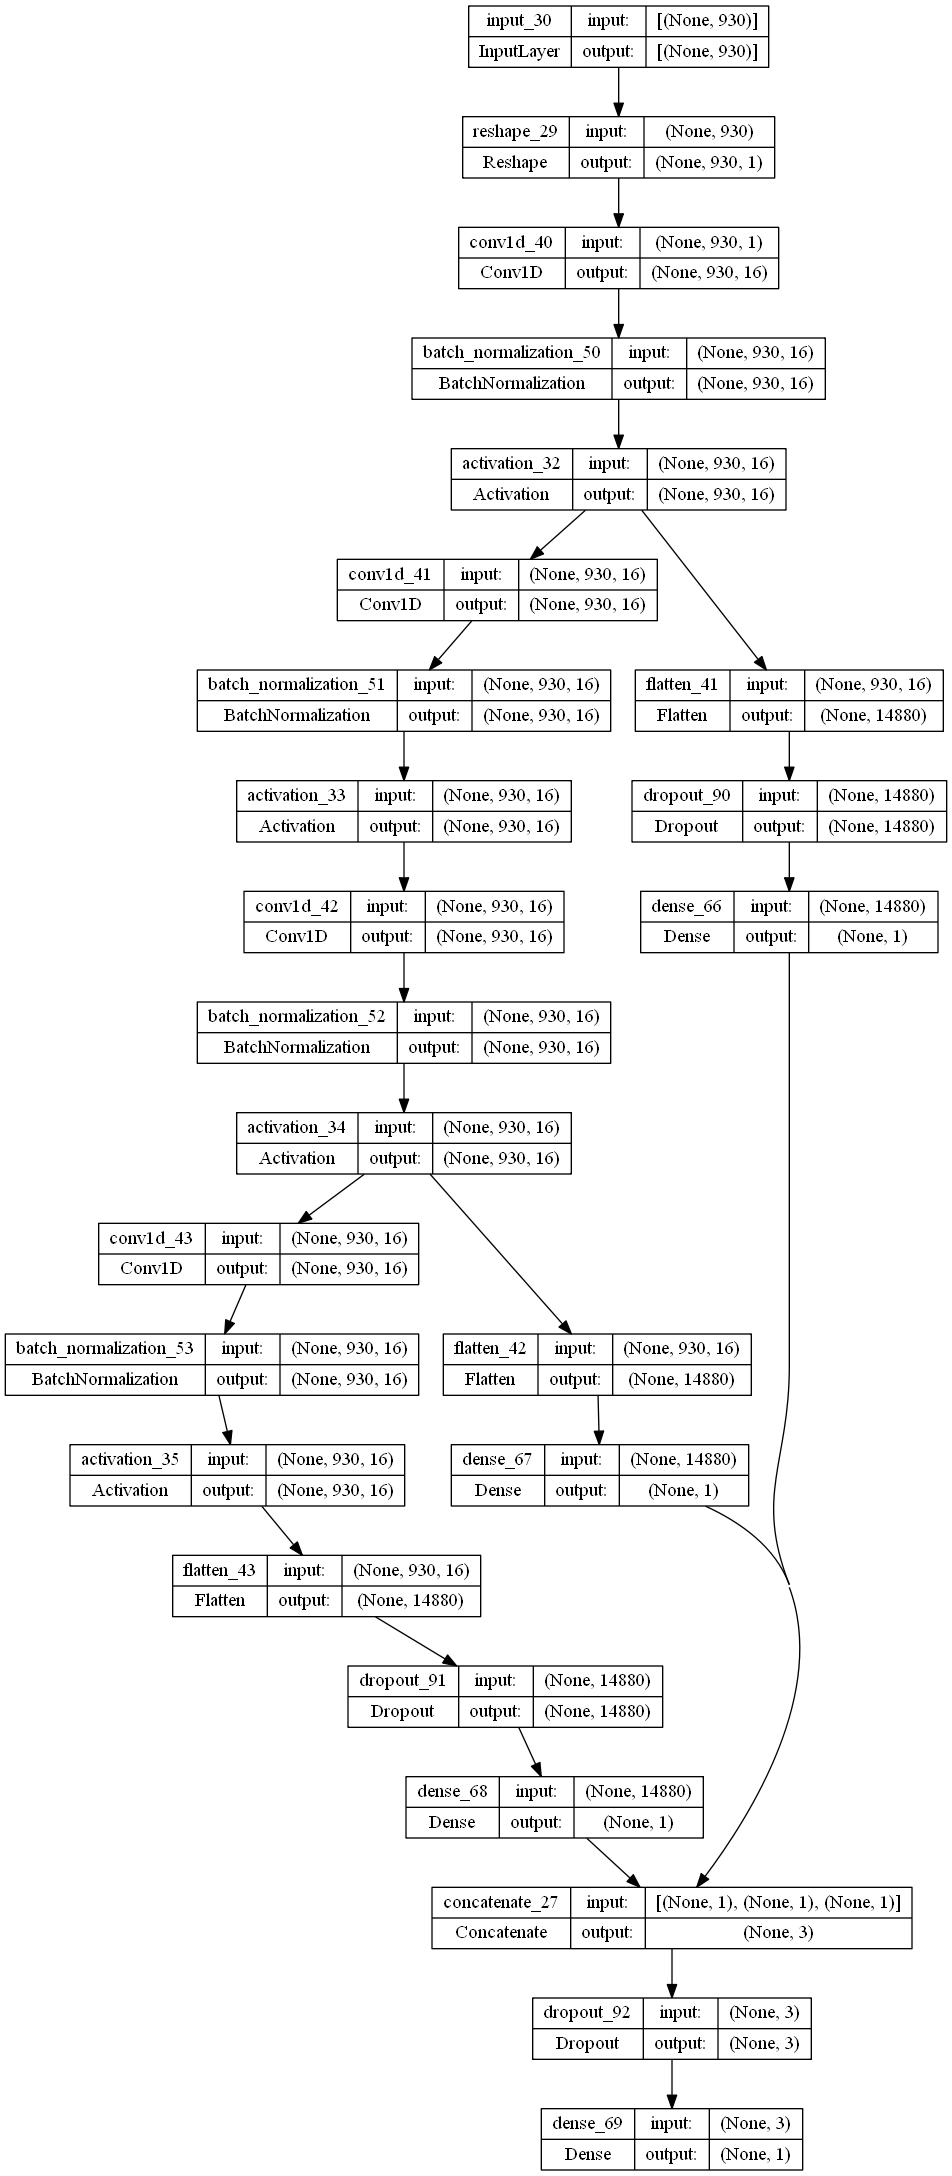

In [99]:

from keras.utils.vis_utils import plot_model
plot_model(get_model_CNN(), show_shapes=True, show_layer_names=True)

In [31]:
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    
    #loss_bin_cross = -tf.reduce_mean(y_true*tf.math.log((y_pred))+(1-y_true)*tf.math.log((1-y_pred)))
    
    loss_BC = tf.keras.losses.BinaryCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE)
    
    loss_dist = tf.reduce_mean(y_true*tf.math.log1p(y_pred)+(1-y_true)*tf.math.log1p(1-y_pred))
    
    loss_mse = tf.keras.losses.MeanSquaredError()
    
    loss_logcosh = tf.keras.losses.LogCosh()
    
    loss_kld = tf.keras.losses.KLDivergence()
    
    loss_finale = loss_BC(y_true,y_pred) + loss_mse(y_true,y_pred) + loss_logcosh(y_true,y_pred)
    
    return loss_finale


In [61]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(X_train_tail,y_train_tail)):
    X_train, X_val = X_train_tail[train_indices], X_train_tail[valid_indices]
    y_train, y_val = y_train_tail.iloc[train_indices], y_train_tail.iloc[valid_indices]
    print(X_train.shape,X_val.shape)
    train_ds = make_dataset(X_train, y_train)
    valid_ds = make_dataset(X_val,  y_val, mode="valid")
    del X_train,X_val,y_train,y_val
    model = get_model_CNN()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_CNN_kfold{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience = 10,monitor='val_accuracy',verbose = 1, mode = 'max',restore_best_weights=True)
    history = model.fit(train_ds,validation_data = valid_ds, epochs = 30, callbacks=[checkpoint, early_stop])
    model = keras.models.load_model(f"model_CNN_kfold{index}")
    models.append(model)
    del train_ds, valid_ds
    yo_tail = model.predict(X_test_tail)
    print(amex_metric_pytorch(torch.tensor(y_test_tail.to_numpy()), torch.tensor(yo_tail.ravel())))

(253704, 558) (63426, 558)
Epoch 1/30
124/124 [==============================] - ETA: 0s - loss: 0.2570 - tp: 61598.0000 - fp: 16402.0000 - tn: 208578.0000 - fn: 17126.0000 - accuracy: 0.8896 - precision: 0.7897 - recall: 0.7825 - auc: 0.9499 - prc: 0.8685

INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


124/124 [==============================] - 130s 955ms/step - loss: 0.2570 - tp: 61598.0000 - fp: 16402.0000 - tn: 208578.0000 - fn: 17126.0000 - accuracy: 0.8896 - precision: 0.7897 - recall: 0.7825 - auc: 0.9499 - prc: 0.8685 - val_loss: 0.2526 - val_tp: 14564.0000 - val_fp: 5306.0000 - val_tn: 41635.0000 - val_fn: 1921.0000 - val_accuracy: 0.8861 - val_precision: 0.7330 - val_recall: 0.8835 - val_auc: 0.9559 - val_prc: 0.8844
Epoch 2/30
124/124 [==============================] - ETA: 0s - loss: 0.2294 - tp: 52629.0000 - fp: 12364.0000 - tn: 175399.0000 - fn: 13312.0000 - accuracy: 0.8988 - precision: 0.8098 - recall: 0.7981 - auc: 0.9572 - prc: 0.8883

INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


124/124 [==============================] - 115s 921ms/step - loss: 0.2294 - tp: 52629.0000 - fp: 12364.0000 - tn: 175399.0000 - fn: 13312.0000 - accuracy: 0.8988 - precision: 0.8098 - recall: 0.7981 - auc: 0.9572 - prc: 0.8883 - val_loss: 0.2316 - val_tp: 13947.0000 - val_fp: 4056.0000 - val_tn: 42885.0000 - val_fn: 2538.0000 - val_accuracy: 0.8960 - val_precision: 0.7747 - val_recall: 0.8460 - val_auc: 0.9579 - val_prc: 0.8897
Epoch 3/30
124/124 [==============================] - ETA: 0s - loss: 0.2252 - tp: 52971.0000 - fp: 12203.0000 - tn: 175560.0000 - fn: 12970.0000 - accuracy: 0.9008 - precision: 0.8128 - recall: 0.8033 - auc: 0.9588 - prc: 0.8923

INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


124/124 [==============================] - 99s 797ms/step - loss: 0.2252 - tp: 52971.0000 - fp: 12203.0000 - tn: 175560.0000 - fn: 12970.0000 - accuracy: 0.9008 - precision: 0.8128 - recall: 0.8033 - auc: 0.9588 - prc: 0.8923 - val_loss: 0.2275 - val_tp: 13696.0000 - val_fp: 3651.0000 - val_tn: 43290.0000 - val_fn: 2789.0000 - val_accuracy: 0.8985 - val_precision: 0.7895 - val_recall: 0.8308 - val_auc: 0.9585 - val_prc: 0.8915
Epoch 4/30
124/124 [==============================] - ETA: 0s - loss: 0.2224 - tp: 53285.0000 - fp: 12047.0000 - tn: 175716.0000 - fn: 12656.0000 - accuracy: 0.9026 - precision: 0.8156 - recall: 0.8081 - auc: 0.9597 - prc: 0.8955

INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


124/124 [==============================] - 102s 812ms/step - loss: 0.2224 - tp: 53285.0000 - fp: 12047.0000 - tn: 175716.0000 - fn: 12656.0000 - accuracy: 0.9026 - precision: 0.8156 - recall: 0.8081 - auc: 0.9597 - prc: 0.8955 - val_loss: 0.2270 - val_tp: 13698.0000 - val_fp: 3621.0000 - val_tn: 43320.0000 - val_fn: 2787.0000 - val_accuracy: 0.8990 - val_precision: 0.7909 - val_recall: 0.8309 - val_auc: 0.9587 - val_prc: 0.8918
Epoch 5/30
124/124 [==============================] - 96s 775ms/step - loss: 0.2210 - tp: 53380.0000 - fp: 11998.0000 - tn: 175765.0000 - fn: 12561.0000 - accuracy: 0.9032 - precision: 0.8165 - recall: 0.8095 - auc: 0.9602 - prc: 0.8969 - val_loss: 0.2270 - val_tp: 13699.0000 - val_fp: 3652.0000 - val_tn: 43289.0000 - val_fn: 2786.0000 - val_accuracy: 0.8985 - val_precision: 0.7895 - val_recall: 0.8310 - val_auc: 0.9587 - val_prc: 0.8923
Epoch 6/30
124/124 [==============================] - ETA: 0s - loss: 0.2191 - tp: 53511.0000 - fp: 11916.0000 - tn: 175847.00

INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


124/124 [==============================] - 108s 876ms/step - loss: 0.2191 - tp: 53511.0000 - fp: 11916.0000 - tn: 175847.0000 - fn: 12430.0000 - accuracy: 0.9040 - precision: 0.8179 - recall: 0.8115 - auc: 0.9609 - prc: 0.8987 - val_loss: 0.2261 - val_tp: 13645.0000 - val_fp: 3567.0000 - val_tn: 43374.0000 - val_fn: 2840.0000 - val_accuracy: 0.8990 - val_precision: 0.7928 - val_recall: 0.8277 - val_auc: 0.9589 - val_prc: 0.8929
Epoch 7/30
124/124 [==============================] - ETA: 0s - loss: 0.2175 - tp: 53645.0000 - fp: 11830.0000 - tn: 175933.0000 - fn: 12296.0000 - accuracy: 0.9049 - precision: 0.8193 - recall: 0.8135 - auc: 0.9615 - prc: 0.9004

INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


INFO:tensorflow:Assets written to: model_CNN_kfold0\assets


124/124 [==============================] - 94s 756ms/step - loss: 0.2175 - tp: 53645.0000 - fp: 11830.0000 - tn: 175933.0000 - fn: 12296.0000 - accuracy: 0.9049 - precision: 0.8193 - recall: 0.8135 - auc: 0.9615 - prc: 0.9004 - val_loss: 0.2255 - val_tp: 13633.0000 - val_fp: 3521.0000 - val_tn: 43420.0000 - val_fn: 2852.0000 - val_accuracy: 0.8995 - val_precision: 0.7947 - val_recall: 0.8270 - val_auc: 0.9592 - val_prc: 0.8932
Epoch 8/30
124/124 [==============================] - 83s 667ms/step - loss: 0.2157 - tp: 53733.0000 - fp: 11777.0000 - tn: 175986.0000 - fn: 12208.0000 - accuracy: 0.9055 - precision: 0.8202 - recall: 0.8149 - auc: 0.9621 - prc: 0.9024 - val_loss: 0.2263 - val_tp: 13604.0000 - val_fp: 3507.0000 - val_tn: 43434.0000 - val_fn: 2881.0000 - val_accuracy: 0.8993 - val_precision: 0.7950 - val_recall: 0.8252 - val_auc: 0.9591 - val_prc: 0.8923
Epoch 9/30
124/124 [==============================] - 81s 657ms/step - loss: 0.2147 - tp: 53878.0000 - fp: 11670.0000 - tn: 176

INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


124/124 [==============================] - 123s 889ms/step - loss: 0.2530 - tp: 64863.0000 - fp: 16924.0000 - tn: 217780.0000 - fn: 17563.0000 - accuracy: 0.8913 - precision: 0.7931 - recall: 0.7869 - auc: 0.9509 - prc: 0.8717 - val_loss: 0.2441 - val_tp: 14402.0000 - val_fp: 4805.0000 - val_tn: 42136.0000 - val_fn: 2083.0000 - val_accuracy: 0.8914 - val_precision: 0.7498 - val_recall: 0.8736 - val_auc: 0.9567 - val_prc: 0.8851
Epoch 2/30
124/124 [==============================] - ETA: 0s - loss: 0.2278 - tp: 52664.0000 - fp: 12410.0000 - tn: 175353.0000 - fn: 13277.0000 - accuracy: 0.8988 - precision: 0.8093 - recall: 0.7987 - auc: 0.9578 - prc: 0.8902

INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


124/124 [==============================] - 102s 823ms/step - loss: 0.2278 - tp: 52664.0000 - fp: 12410.0000 - tn: 175353.0000 - fn: 13277.0000 - accuracy: 0.8988 - precision: 0.8093 - recall: 0.7987 - auc: 0.9578 - prc: 0.8902 - val_loss: 0.2280 - val_tp: 13664.0000 - val_fp: 3550.0000 - val_tn: 43391.0000 - val_fn: 2821.0000 - val_accuracy: 0.8996 - val_precision: 0.7938 - val_recall: 0.8289 - val_auc: 0.9584 - val_prc: 0.8903
Epoch 3/30
124/124 [==============================] - ETA: 0s - loss: 0.2239 - tp: 53089.0000 - fp: 12244.0000 - tn: 175519.0000 - fn: 12852.0000 - accuracy: 0.9011 - precision: 0.8126 - recall: 0.8051 - auc: 0.9591 - prc: 0.8941

INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


124/124 [==============================] - 99s 796ms/step - loss: 0.2239 - tp: 53089.0000 - fp: 12244.0000 - tn: 175519.0000 - fn: 12852.0000 - accuracy: 0.9011 - precision: 0.8126 - recall: 0.8051 - auc: 0.9591 - prc: 0.8941 - val_loss: 0.2262 - val_tp: 13528.0000 - val_fp: 3346.0000 - val_tn: 43595.0000 - val_fn: 2957.0000 - val_accuracy: 0.9006 - val_precision: 0.8017 - val_recall: 0.8206 - val_auc: 0.9587 - val_prc: 0.8915
Epoch 4/30
124/124 [==============================] - 88s 708ms/step - loss: 0.2216 - tp: 53253.0000 - fp: 12188.0000 - tn: 175575.0000 - fn: 12688.0000 - accuracy: 0.9019 - precision: 0.8138 - recall: 0.8076 - auc: 0.9599 - prc: 0.8963 - val_loss: 0.2267 - val_tp: 13567.0000 - val_fp: 3352.0000 - val_tn: 43589.0000 - val_fn: 2918.0000 - val_accuracy: 0.9011 - val_precision: 0.8019 - val_recall: 0.8230 - val_auc: 0.9587 - val_prc: 0.8910
Epoch 5/30
124/124 [==============================] - ETA: 0s - loss: 0.2193 - tp: 53452.0000 - fp: 12052.0000 - tn: 175711.000

INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


124/124 [==============================] - 101s 813ms/step - loss: 0.2193 - tp: 53452.0000 - fp: 12052.0000 - tn: 175711.0000 - fn: 12489.0000 - accuracy: 0.9033 - precision: 0.8160 - recall: 0.8106 - auc: 0.9608 - prc: 0.8986 - val_loss: 0.2260 - val_tp: 13442.0000 - val_fp: 3210.0000 - val_tn: 43731.0000 - val_fn: 3043.0000 - val_accuracy: 0.9014 - val_precision: 0.8072 - val_recall: 0.8154 - val_auc: 0.9589 - val_prc: 0.8912
Epoch 6/30
124/124 [==============================] - ETA: 0s - loss: 0.2178 - tp: 53566.0000 - fp: 11877.0000 - tn: 175886.0000 - fn: 12375.0000 - accuracy: 0.9044 - precision: 0.8185 - recall: 0.8123 - auc: 0.9613 - prc: 0.9005

INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


INFO:tensorflow:Assets written to: model_CNN_kfold1\assets


124/124 [==============================] - 101s 812ms/step - loss: 0.2178 - tp: 53566.0000 - fp: 11877.0000 - tn: 175886.0000 - fn: 12375.0000 - accuracy: 0.9044 - precision: 0.8185 - recall: 0.8123 - auc: 0.9613 - prc: 0.9005 - val_loss: 0.2259 - val_tp: 13461.0000 - val_fp: 3235.0000 - val_tn: 43706.0000 - val_fn: 3024.0000 - val_accuracy: 0.9013 - val_precision: 0.8062 - val_recall: 0.8166 - val_auc: 0.9590 - val_prc: 0.8917
Epoch 7/30
124/124 [==============================] - 92s 740ms/step - loss: 0.2160 - tp: 53747.0000 - fp: 11840.0000 - tn: 175923.0000 - fn: 12194.0000 - accuracy: 0.9053 - precision: 0.8195 - recall: 0.8151 - auc: 0.9619 - prc: 0.9022 - val_loss: 0.2262 - val_tp: 13522.0000 - val_fp: 3264.0000 - val_tn: 43677.0000 - val_fn: 2963.0000 - val_accuracy: 0.9018 - val_precision: 0.8056 - val_recall: 0.8203 - val_auc: 0.9589 - val_prc: 0.8915
Epoch 8/30
124/124 [==============================] - 92s 742ms/step - loss: 0.2144 - tp: 53838.0000 - fp: 11741.0000 - tn: 17

INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


124/124 [==============================] - 118s 863ms/step - loss: 0.2564 - tp: 64625.0000 - fp: 17002.0000 - tn: 217702.0000 - fn: 17801.0000 - accuracy: 0.8903 - precision: 0.7917 - recall: 0.7840 - auc: 0.9502 - prc: 0.8692 - val_loss: 0.2481 - val_tp: 14343.0000 - val_fp: 4921.0000 - val_tn: 42020.0000 - val_fn: 2142.0000 - val_accuracy: 0.8886 - val_precision: 0.7445 - val_recall: 0.8701 - val_auc: 0.9546 - val_prc: 0.8818
Epoch 2/30
124/124 [==============================] - ETA: 0s - loss: 0.2285 - tp: 52613.0000 - fp: 12393.0000 - tn: 175370.0000 - fn: 13328.0000 - accuracy: 0.8986 - precision: 0.8094 - recall: 0.7979 - auc: 0.9575 - prc: 0.8890

INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


124/124 [==============================] - 97s 779ms/step - loss: 0.2285 - tp: 52613.0000 - fp: 12393.0000 - tn: 175370.0000 - fn: 13328.0000 - accuracy: 0.8986 - precision: 0.8094 - recall: 0.7979 - auc: 0.9575 - prc: 0.8890 - val_loss: 0.2314 - val_tp: 13668.0000 - val_fp: 3705.0000 - val_tn: 43236.0000 - val_fn: 2817.0000 - val_accuracy: 0.8972 - val_precision: 0.7867 - val_recall: 0.8291 - val_auc: 0.9570 - val_prc: 0.8884
Epoch 3/30
124/124 [==============================] - ETA: 0s - loss: 0.2249 - tp: 52885.0000 - fp: 12269.0000 - tn: 175494.0000 - fn: 13056.0000 - accuracy: 0.9002 - precision: 0.8117 - recall: 0.8020 - auc: 0.9589 - prc: 0.8930

INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


124/124 [==============================] - 96s 775ms/step - loss: 0.2249 - tp: 52885.0000 - fp: 12269.0000 - tn: 175494.0000 - fn: 13056.0000 - accuracy: 0.9002 - precision: 0.8117 - recall: 0.8020 - auc: 0.9589 - prc: 0.8930 - val_loss: 0.2286 - val_tp: 13538.0000 - val_fp: 3460.0000 - val_tn: 43481.0000 - val_fn: 2947.0000 - val_accuracy: 0.8990 - val_precision: 0.7964 - val_recall: 0.8212 - val_auc: 0.9577 - val_prc: 0.8904
Epoch 4/30
124/124 [==============================] - ETA: 0s - loss: 0.2219 - tp: 53208.0000 - fp: 12124.0000 - tn: 175639.0000 - fn: 12733.0000 - accuracy: 0.9020 - precision: 0.8144 - recall: 0.8069 - auc: 0.9599 - prc: 0.8959

INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


124/124 [==============================] - 94s 763ms/step - loss: 0.2219 - tp: 53208.0000 - fp: 12124.0000 - tn: 175639.0000 - fn: 12733.0000 - accuracy: 0.9020 - precision: 0.8144 - recall: 0.8069 - auc: 0.9599 - prc: 0.8959 - val_loss: 0.2281 - val_tp: 13624.0000 - val_fp: 3510.0000 - val_tn: 43431.0000 - val_fn: 2861.0000 - val_accuracy: 0.8996 - val_precision: 0.7951 - val_recall: 0.8264 - val_auc: 0.9580 - val_prc: 0.8911
Epoch 5/30
124/124 [==============================] - ETA: 0s - loss: 0.2201 - tp: 53378.0000 - fp: 12101.0000 - tn: 175662.0000 - fn: 12563.0000 - accuracy: 0.9028 - precision: 0.8152 - recall: 0.8095 - auc: 0.9606 - prc: 0.8977

INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


124/124 [==============================] - 93s 752ms/step - loss: 0.2201 - tp: 53378.0000 - fp: 12101.0000 - tn: 175662.0000 - fn: 12563.0000 - accuracy: 0.9028 - precision: 0.8152 - recall: 0.8095 - auc: 0.9606 - prc: 0.8977 - val_loss: 0.2278 - val_tp: 13621.0000 - val_fp: 3479.0000 - val_tn: 43462.0000 - val_fn: 2864.0000 - val_accuracy: 0.9000 - val_precision: 0.7965 - val_recall: 0.8263 - val_auc: 0.9581 - val_prc: 0.8916
Epoch 6/30
124/124 [==============================] - ETA: 0s - loss: 0.2180 - tp: 53412.0000 - fp: 11933.0000 - tn: 175830.0000 - fn: 12529.0000 - accuracy: 0.9036 - precision: 0.8174 - recall: 0.8100 - auc: 0.9613 - prc: 0.8996

INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


INFO:tensorflow:Assets written to: model_CNN_kfold2\assets


124/124 [==============================] - 95s 768ms/step - loss: 0.2180 - tp: 53412.0000 - fp: 11933.0000 - tn: 175830.0000 - fn: 12529.0000 - accuracy: 0.9036 - precision: 0.8174 - recall: 0.8100 - auc: 0.9613 - prc: 0.8996 - val_loss: 0.2275 - val_tp: 13592.0000 - val_fp: 3431.0000 - val_tn: 43510.0000 - val_fn: 2893.0000 - val_accuracy: 0.9003 - val_precision: 0.7984 - val_recall: 0.8245 - val_auc: 0.9582 - val_prc: 0.8918
Epoch 7/30
124/124 [==============================] - 83s 669ms/step - loss: 0.2164 - tp: 53554.0000 - fp: 11871.0000 - tn: 175892.0000 - fn: 12387.0000 - accuracy: 0.9044 - precision: 0.8186 - recall: 0.8122 - auc: 0.9618 - prc: 0.9013 - val_loss: 0.2275 - val_tp: 13548.0000 - val_fp: 3380.0000 - val_tn: 43561.0000 - val_fn: 2937.0000 - val_accuracy: 0.9004 - val_precision: 0.8003 - val_recall: 0.8218 - val_auc: 0.9583 - val_prc: 0.8921
Epoch 8/30
124/124 [==============================] - 83s 672ms/step - loss: 0.2153 - tp: 53777.0000 - fp: 11815.0000 - tn: 175

INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


124/124 [==============================] - 117s 859ms/step - loss: 0.2581 - tp: 64474.0000 - fp: 17332.0000 - tn: 217372.0000 - fn: 17952.0000 - accuracy: 0.8887 - precision: 0.7881 - recall: 0.7822 - auc: 0.9489 - prc: 0.8685 - val_loss: 0.2426 - val_tp: 14549.0000 - val_fp: 4920.0000 - val_tn: 42021.0000 - val_fn: 1936.0000 - val_accuracy: 0.8919 - val_precision: 0.7473 - val_recall: 0.8826 - val_auc: 0.9576 - val_prc: 0.8887
Epoch 2/30
124/124 [==============================] - ETA: 0s - loss: 0.2297 - tp: 52519.0000 - fp: 12313.0000 - tn: 175450.0000 - fn: 13422.0000 - accuracy: 0.8986 - precision: 0.8101 - recall: 0.7965 - auc: 0.9571 - prc: 0.8881

INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


124/124 [==============================] - 106s 854ms/step - loss: 0.2297 - tp: 52519.0000 - fp: 12313.0000 - tn: 175450.0000 - fn: 13422.0000 - accuracy: 0.8986 - precision: 0.8101 - recall: 0.7965 - auc: 0.9571 - prc: 0.8881 - val_loss: 0.2256 - val_tp: 13760.0000 - val_fp: 3677.0000 - val_tn: 43264.0000 - val_fn: 2725.0000 - val_accuracy: 0.8991 - val_precision: 0.7891 - val_recall: 0.8347 - val_auc: 0.9591 - val_prc: 0.8933
Epoch 3/30
124/124 [==============================] - ETA: 0s - loss: 0.2261 - tp: 52822.0000 - fp: 12275.0000 - tn: 175488.0000 - fn: 13119.0000 - accuracy: 0.8999 - precision: 0.8114 - recall: 0.8010 - auc: 0.9584 - prc: 0.8919

INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


124/124 [==============================] - 106s 858ms/step - loss: 0.2261 - tp: 52822.0000 - fp: 12275.0000 - tn: 175488.0000 - fn: 13119.0000 - accuracy: 0.8999 - precision: 0.8114 - recall: 0.8010 - auc: 0.9584 - prc: 0.8919 - val_loss: 0.2248 - val_tp: 13871.0000 - val_fp: 3731.0000 - val_tn: 43210.0000 - val_fn: 2614.0000 - val_accuracy: 0.9000 - val_precision: 0.7880 - val_recall: 0.8414 - val_auc: 0.9596 - val_prc: 0.8944
Epoch 4/30
124/124 [==============================] - ETA: 0s - loss: 0.2234 - tp: 53073.0000 - fp: 12156.0000 - tn: 175607.0000 - fn: 12868.0000 - accuracy: 0.9014 - precision: 0.8136 - recall: 0.8049 - auc: 0.9593 - prc: 0.8946

INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


124/124 [==============================] - 102s 821ms/step - loss: 0.2234 - tp: 53073.0000 - fp: 12156.0000 - tn: 175607.0000 - fn: 12868.0000 - accuracy: 0.9014 - precision: 0.8136 - recall: 0.8049 - auc: 0.9593 - prc: 0.8946 - val_loss: 0.2246 - val_tp: 13904.0000 - val_fp: 3717.0000 - val_tn: 43224.0000 - val_fn: 2581.0000 - val_accuracy: 0.9007 - val_precision: 0.7891 - val_recall: 0.8434 - val_auc: 0.9598 - val_prc: 0.8946
Epoch 5/30
124/124 [==============================] - ETA: 0s - loss: 0.2212 - tp: 53300.0000 - fp: 12006.0000 - tn: 175757.0000 - fn: 12641.0000 - accuracy: 0.9029 - precision: 0.8162 - recall: 0.8083 - auc: 0.9601 - prc: 0.8968

INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


124/124 [==============================] - 102s 821ms/step - loss: 0.2212 - tp: 53300.0000 - fp: 12006.0000 - tn: 175757.0000 - fn: 12641.0000 - accuracy: 0.9029 - precision: 0.8162 - recall: 0.8083 - auc: 0.9601 - prc: 0.8968 - val_loss: 0.2233 - val_tp: 13840.0000 - val_fp: 3604.0000 - val_tn: 43337.0000 - val_fn: 2645.0000 - val_accuracy: 0.9015 - val_precision: 0.7934 - val_recall: 0.8396 - val_auc: 0.9599 - val_prc: 0.8955
Epoch 6/30
124/124 [==============================] - ETA: 0s - loss: 0.2198 - tp: 53327.0000 - fp: 11977.0000 - tn: 175786.0000 - fn: 12614.0000 - accuracy: 0.9031 - precision: 0.8166 - recall: 0.8087 - auc: 0.9606 - prc: 0.8984

INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


INFO:tensorflow:Assets written to: model_CNN_kfold3\assets


124/124 [==============================] - 102s 825ms/step - loss: 0.2198 - tp: 53327.0000 - fp: 11977.0000 - tn: 175786.0000 - fn: 12614.0000 - accuracy: 0.9031 - precision: 0.8166 - recall: 0.8087 - auc: 0.9606 - prc: 0.8984 - val_loss: 0.2225 - val_tp: 13850.0000 - val_fp: 3581.0000 - val_tn: 43360.0000 - val_fn: 2635.0000 - val_accuracy: 0.9020 - val_precision: 0.7946 - val_recall: 0.8402 - val_auc: 0.9603 - val_prc: 0.8958
Epoch 7/30
124/124 [==============================] - 92s 743ms/step - loss: 0.2179 - tp: 53540.0000 - fp: 11993.0000 - tn: 175770.0000 - fn: 12401.0000 - accuracy: 0.9038 - precision: 0.8170 - recall: 0.8119 - auc: 0.9613 - prc: 0.9001 - val_loss: 0.2232 - val_tp: 13892.0000 - val_fp: 3638.0000 - val_tn: 43303.0000 - val_fn: 2593.0000 - val_accuracy: 0.9018 - val_precision: 0.7925 - val_recall: 0.8427 - val_auc: 0.9602 - val_prc: 0.8960
Epoch 8/30
124/124 [==============================] - 92s 742ms/step - loss: 0.2165 - tp: 53639.0000 - fp: 11902.0000 - tn: 17

INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


124/124 [==============================] - 114s 875ms/step - loss: 0.2620 - tp: 64652.0000 - fp: 17745.0000 - tn: 216960.0000 - fn: 17773.0000 - accuracy: 0.8880 - precision: 0.7846 - recall: 0.7844 - auc: 0.9485 - prc: 0.8662 - val_loss: 0.2483 - val_tp: 14475.0000 - val_fp: 5122.0000 - val_tn: 41818.0000 - val_fn: 2011.0000 - val_accuracy: 0.8875 - val_precision: 0.7386 - val_recall: 0.8780 - val_auc: 0.9555 - val_prc: 0.8841
Epoch 2/30
124/124 [==============================] - ETA: 0s - loss: 0.2289 - tp: 52592.0000 - fp: 12362.0000 - tn: 175402.0000 - fn: 13348.0000 - accuracy: 0.8987 - precision: 0.8097 - recall: 0.7976 - auc: 0.9574 - prc: 0.8890

INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


124/124 [==============================] - 99s 799ms/step - loss: 0.2289 - tp: 52592.0000 - fp: 12362.0000 - tn: 175402.0000 - fn: 13348.0000 - accuracy: 0.8987 - precision: 0.8097 - recall: 0.7976 - auc: 0.9574 - prc: 0.8890 - val_loss: 0.2297 - val_tp: 13632.0000 - val_fp: 3593.0000 - val_tn: 43347.0000 - val_fn: 2854.0000 - val_accuracy: 0.8984 - val_precision: 0.7914 - val_recall: 0.8269 - val_auc: 0.9575 - val_prc: 0.8895
Epoch 3/30
124/124 [==============================] - ETA: 0s - loss: 0.2245 - tp: 53005.0000 - fp: 12237.0000 - tn: 175527.0000 - fn: 12935.0000 - accuracy: 0.9008 - precision: 0.8124 - recall: 0.8038 - auc: 0.9589 - prc: 0.8932

INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


124/124 [==============================] - 122s 985ms/step - loss: 0.2245 - tp: 53005.0000 - fp: 12237.0000 - tn: 175527.0000 - fn: 12935.0000 - accuracy: 0.9008 - precision: 0.8124 - recall: 0.8038 - auc: 0.9589 - prc: 0.8932 - val_loss: 0.2266 - val_tp: 13381.0000 - val_fp: 3244.0000 - val_tn: 43696.0000 - val_fn: 3105.0000 - val_accuracy: 0.8999 - val_precision: 0.8049 - val_recall: 0.8117 - val_auc: 0.9583 - val_prc: 0.8914
Epoch 4/30
124/124 [==============================] - ETA: 0s - loss: 0.2222 - tp: 53147.0000 - fp: 12143.0000 - tn: 175621.0000 - fn: 12793.0000 - accuracy: 0.9017 - precision: 0.8140 - recall: 0.8060 - auc: 0.9598 - prc: 0.8955

INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


124/124 [==============================] - 120s 972ms/step - loss: 0.2222 - tp: 53147.0000 - fp: 12143.0000 - tn: 175621.0000 - fn: 12793.0000 - accuracy: 0.9017 - precision: 0.8140 - recall: 0.8060 - auc: 0.9598 - prc: 0.8955 - val_loss: 0.2257 - val_tp: 13437.0000 - val_fp: 3264.0000 - val_tn: 43676.0000 - val_fn: 3049.0000 - val_accuracy: 0.9005 - val_precision: 0.8046 - val_recall: 0.8151 - val_auc: 0.9587 - val_prc: 0.8926
Epoch 5/30
124/124 [==============================] - 104s 831ms/step - loss: 0.2201 - tp: 53450.0000 - fp: 12012.0000 - tn: 175752.0000 - fn: 12490.0000 - accuracy: 0.9034 - precision: 0.8165 - recall: 0.8106 - auc: 0.9606 - prc: 0.8978 - val_loss: 0.2259 - val_tp: 13382.0000 - val_fp: 3216.0000 - val_tn: 43724.0000 - val_fn: 3104.0000 - val_accuracy: 0.9004 - val_precision: 0.8062 - val_recall: 0.8117 - val_auc: 0.9588 - val_prc: 0.8929
Epoch 6/30
124/124 [==============================] - ETA: 0s - loss: 0.2185 - tp: 53505.0000 - fp: 11911.0000 - tn: 175853.0

INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


INFO:tensorflow:Assets written to: model_CNN_kfold4\assets


124/124 [==============================] - 104s 839ms/step - loss: 0.2185 - tp: 53505.0000 - fp: 11911.0000 - tn: 175853.0000 - fn: 12435.0000 - accuracy: 0.9040 - precision: 0.8179 - recall: 0.8114 - auc: 0.9611 - prc: 0.8992 - val_loss: 0.2254 - val_tp: 13392.0000 - val_fp: 3200.0000 - val_tn: 43740.0000 - val_fn: 3094.0000 - val_accuracy: 0.9008 - val_precision: 0.8071 - val_recall: 0.8123 - val_auc: 0.9588 - val_prc: 0.8930
Epoch 7/30
124/124 [==============================] - 104s 840ms/step - loss: 0.2170 - tp: 53590.0000 - fp: 11877.0000 - tn: 175887.0000 - fn: 12350.0000 - accuracy: 0.9045 - precision: 0.8186 - recall: 0.8127 - auc: 0.9616 - prc: 0.9009 - val_loss: 0.2259 - val_tp: 13346.0000 - val_fp: 3156.0000 - val_tn: 43784.0000 - val_fn: 3140.0000 - val_accuracy: 0.9007 - val_precision: 0.8088 - val_recall: 0.8095 - val_auc: 0.9587 - val_prc: 0.8928
Epoch 8/30
124/124 [==============================] - 96s 771ms/step - loss: 0.2153 - tp: 53724.0000 - fp: 11747.0000 - tn: 1

In [62]:
yo = []
for model in models:
    yo_tail = model.predict(X_test)
    yo.append(yo_tail)
    print(amex_metric_pytorch(torch.tensor(y_test.to_numpy()), torch.tensor(yo_tail.ravel())))
    
#ya = []
#for model in models_logcosh:
#    yo_tail = model.predict(X_test)
#    yo.append(yo_tail)
#    print(amex_metric_pytorch(torch.tensor(y_test.to_numpy()), torch.tensor(yo_tail.ravel())))

2869/2869 [==============================] - 31s 11ms/step
tensor(0.7867, dtype=torch.float64)
2869/2869 [==============================] - 30s 11ms/step
tensor(0.7852, dtype=torch.float64)
2869/2869 [==============================] - 31s 11ms/step
tensor(0.7854, dtype=torch.float64)
2869/2869 [==============================] - 32s 11ms/step
tensor(0.7852, dtype=torch.float64)
2869/2869 [==============================] - 32s 11ms/step
tensor(0.7855, dtype=torch.float64)


In [63]:
pred_f = yo[0]
i = 0
for pred in yo[1:]:
    print(i)
    pred_f += pred
#for pred in ya:
#    print(i)
#    pred_f += pred

0
0
0
0


In [64]:
print(amex_metric_pytorch(torch.tensor(y_test.to_numpy()), torch.tensor((pred_f/5).ravel())))

tensor(0.7883, dtype=torch.float64)


# In here I tried to boost up my results based on current estimates.... but it did not help in the leaderboard

In [76]:
def get_model_boost():
    
    features_inputs = tf.keras.Input((5, ), dtype=tf.float16)
    
    x = layers.Dense(64, activation='swish')(features_inputs)
   
    output = layers.Dense(1,activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.0001),  loss = 'binary_crossentropy', metrics=METRICS)
    return model

In [66]:
yo_test = []
yo_train = []
for model in models:
    yo_tail = model.predict(X_test_tail)
    yo_train_ = model.predict(X_test)
    yo_test.append(yo_tail)
    yo_train.append(yo_train_)
    #print(amex_metric_pytorch(torch.tensor(y_test.to_numpy()), torch.tensor(yo_tail.ravel())))


2869/2869 [==============================] - 33s 11ms/step


In [69]:
X_train_ = np.hstack((yo_train[0],yo_train[1],yo_train[2],yo_train[3],yo_train[4]))#,yo_train[5],yo_train[6],yo_train[7],yo_train[8],yo_train[9]))
X_test_ = np.hstack((yo_test[0],yo_test[1],yo_test[2],yo_test[3],yo_test[4]))#,yo_test[5],yo_test[6],yo_test[7],yo_test[8],yo_test[9]))

In [70]:
train_ds_tail = make_dataset(X_train_,y_test)
val_ds_tail = make_dataset(X_test_,y_test_tail,mode = 'Validation')

In [77]:
model_boost = get_model_boost()
checkpoint = keras.callbacks.ModelCheckpoint(f"B{0}", save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience = 20 ,monitor='val_accuracy',verbose = 1, mode = 'max',restore_best_weights=True)
history = model_boost.fit(train_ds_tail,validation_data = val_ds_tail, epochs = 100, callbacks=[checkpoint, early_stop])
model_boost = keras.models.load_model(f"B{0}")

Epoch 1/100
43/45 [===========================>..] - ETA: 0s - loss: 0.6368 - tp: 25220.0000 - fp: 13697.0000 - tn: 88953.0000 - fn: 10194.0000 - accuracy: 0.8270 - precision: 0.6480 - recall: 0.7121 - auc: 0.8546 - prc: 0.7089

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 21s 291ms/step - loss: 0.6350 - tp: 26160.0000 - fp: 14171.0000 - tn: 91210.0000 - fn: 10242.0000 - accuracy: 0.8278 - precision: 0.6486 - recall: 0.7186 - auc: 0.8562 - prc: 0.7105 - val_loss: 0.6970 - val_tp: 15.0000 - val_fp: 72.0000 - val_tn: 37145.0000 - val_fn: 12768.0000 - val_accuracy: 0.7432 - val_precision: 0.1724 - val_recall: 0.0012 - val_auc: 0.0947 - val_prc: 0.1494
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.5623 - tp: 22557.0000 - fp: 11854.0000 - tn: 56310.0000 - fn: 1062.0000 - accuracy: 0.8593 - precision: 0.6555 - recall: 0.9550 - auc: 0.9393 - prc: 0.7868

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 174ms/step - loss: 0.5623 - tp: 22557.0000 - fp: 11854.0000 - tn: 56310.0000 - fn: 1062.0000 - accuracy: 0.8593 - precision: 0.6555 - recall: 0.9550 - auc: 0.9393 - prc: 0.7868 - val_loss: 0.6689 - val_tp: 1272.0000 - val_fp: 1500.0000 - val_tn: 35717.0000 - val_fn: 11511.0000 - val_accuracy: 0.7398 - val_precision: 0.4589 - val_recall: 0.0995 - val_auc: 0.8493 - val_prc: 0.5120
Epoch 3/100
44/45 [============================>.] - ETA: 0s - loss: 0.5147 - tp: 22004.0000 - fp: 10901.0000 - tn: 56016.0000 - fn: 1191.0000 - accuracy: 0.8658 - precision: 0.6687 - recall: 0.9487 - auc: 0.9526 - prc: 0.8491

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 221ms/step - loss: 0.5143 - tp: 22406.0000 - fp: 11081.0000 - tn: 57083.0000 - fn: 1213.0000 - accuracy: 0.8661 - precision: 0.6691 - recall: 0.9486 - auc: 0.9527 - prc: 0.8494 - val_loss: 0.6399 - val_tp: 11487.0000 - val_fp: 4220.0000 - val_tn: 32997.0000 - val_fn: 1296.0000 - val_accuracy: 0.8897 - val_precision: 0.7313 - val_recall: 0.8986 - val_auc: 0.9489 - val_prc: 0.8006
Epoch 4/100
43/45 [===========================>..] - ETA: 0s - loss: 0.4796 - tp: 21301.0000 - fp: 10010.0000 - tn: 55423.0000 - fn: 1330.0000 - accuracy: 0.8712 - precision: 0.6803 - recall: 0.9412 - auc: 0.9561 - prc: 0.8696

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 214ms/step - loss: 0.4788 - tp: 22225.0000 - fp: 10392.0000 - tn: 57772.0000 - fn: 1394.0000 - accuracy: 0.8716 - precision: 0.6814 - recall: 0.9410 - auc: 0.9561 - prc: 0.8703 - val_loss: 0.6086 - val_tp: 11528.0000 - val_fp: 4133.0000 - val_tn: 33084.0000 - val_fn: 1255.0000 - val_accuracy: 0.8922 - val_precision: 0.7361 - val_recall: 0.9018 - val_auc: 0.9577 - val_prc: 0.8677
Epoch 5/100
44/45 [============================>.] - ETA: 0s - loss: 0.4507 - tp: 21691.0000 - fp: 9624.0000 - tn: 57293.0000 - fn: 1504.0000 - accuracy: 0.8765 - precision: 0.6927 - recall: 0.9352 - auc: 0.9573 - prc: 0.8789

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 196ms/step - loss: 0.4503 - tp: 22091.0000 - fp: 9784.0000 - tn: 58380.0000 - fn: 1528.0000 - accuracy: 0.8768 - precision: 0.6931 - recall: 0.9353 - auc: 0.9574 - prc: 0.8789 - val_loss: 0.5740 - val_tp: 11472.0000 - val_fp: 3928.0000 - val_tn: 33289.0000 - val_fn: 1311.0000 - val_accuracy: 0.8952 - val_precision: 0.7449 - val_recall: 0.8974 - val_auc: 0.9589 - val_prc: 0.8796
Epoch 6/100
43/45 [===========================>..] - ETA: 0s - loss: 0.4265 - tp: 21009.0000 - fp: 8857.0000 - tn: 56576.0000 - fn: 1622.0000 - accuracy: 0.8810 - precision: 0.7034 - recall: 0.9283 - auc: 0.9580 - prc: 0.8823

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 189ms/step - loss: 0.4259 - tp: 21920.0000 - fp: 9195.0000 - tn: 58969.0000 - fn: 1699.0000 - accuracy: 0.8813 - precision: 0.7045 - recall: 0.9281 - auc: 0.9580 - prc: 0.8825 - val_loss: 0.5360 - val_tp: 11413.0000 - val_fp: 3801.0000 - val_tn: 33416.0000 - val_fn: 1370.0000 - val_accuracy: 0.8966 - val_precision: 0.7502 - val_recall: 0.8928 - val_auc: 0.9595 - val_prc: 0.8832
Epoch 7/100
43/45 [===========================>..] - ETA: 0s - loss: 0.4049 - tp: 20824.0000 - fp: 8385.0000 - tn: 57048.0000 - fn: 1807.0000 - accuracy: 0.8843 - precision: 0.7129 - recall: 0.9202 - auc: 0.9584 - prc: 0.8843

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 197ms/step - loss: 0.4043 - tp: 21727.0000 - fp: 8705.0000 - tn: 59459.0000 - fn: 1892.0000 - accuracy: 0.8845 - precision: 0.7140 - recall: 0.9199 - auc: 0.9584 - prc: 0.8846 - val_loss: 0.4956 - val_tp: 11390.0000 - val_fp: 3744.0000 - val_tn: 33473.0000 - val_fn: 1393.0000 - val_accuracy: 0.8973 - val_precision: 0.7526 - val_recall: 0.8910 - val_auc: 0.9601 - val_prc: 0.8874
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 0.3850 - tp: 21554.0000 - fp: 8269.0000 - tn: 59895.0000 - fn: 2065.0000 - accuracy: 0.8874 - precision: 0.7227 - recall: 0.9126 - auc: 0.9587 - prc: 0.8860

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 176ms/step - loss: 0.3850 - tp: 21554.0000 - fp: 8269.0000 - tn: 59895.0000 - fn: 2065.0000 - accuracy: 0.8874 - precision: 0.7227 - recall: 0.9126 - auc: 0.9587 - prc: 0.8860 - val_loss: 0.4555 - val_tp: 11375.0000 - val_fp: 3716.0000 - val_tn: 33501.0000 - val_fn: 1408.0000 - val_accuracy: 0.8975 - val_precision: 0.7538 - val_recall: 0.8899 - val_auc: 0.9603 - val_prc: 0.8879
Epoch 9/100
44/45 [============================>.] - ETA: 0s - loss: 0.3680 - tp: 21005.0000 - fp: 7761.0000 - tn: 59156.0000 - fn: 2190.0000 - accuracy: 0.8896 - precision: 0.7302 - recall: 0.9056 - auc: 0.9587 - prc: 0.8870

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 203ms/step - loss: 0.3677 - tp: 21396.0000 - fp: 7886.0000 - tn: 60278.0000 - fn: 2223.0000 - accuracy: 0.8899 - precision: 0.7307 - recall: 0.9059 - auc: 0.9588 - prc: 0.8871 - val_loss: 0.4177 - val_tp: 11369.0000 - val_fp: 3701.0000 - val_tn: 33516.0000 - val_fn: 1414.0000 - val_accuracy: 0.8977 - val_precision: 0.7544 - val_recall: 0.8894 - val_auc: 0.9607 - val_prc: 0.8893
Epoch 10/100
43/45 [===========================>..] - ETA: 0s - loss: 0.3524 - tp: 20346.0000 - fp: 7222.0000 - tn: 58211.0000 - fn: 2285.0000 - accuracy: 0.8920 - precision: 0.7380 - recall: 0.8990 - auc: 0.9590 - prc: 0.8879

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 179ms/step - loss: 0.3519 - tp: 21228.0000 - fp: 7507.0000 - tn: 60657.0000 - fn: 2391.0000 - accuracy: 0.8922 - precision: 0.7388 - recall: 0.8988 - auc: 0.9590 - prc: 0.8881 - val_loss: 0.3849 - val_tp: 11350.0000 - val_fp: 3670.0000 - val_tn: 33547.0000 - val_fn: 1433.0000 - val_accuracy: 0.8979 - val_precision: 0.7557 - val_recall: 0.8879 - val_auc: 0.9606 - val_prc: 0.8898
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 0.3376 - tp: 21049.0000 - fp: 7154.0000 - tn: 61010.0000 - fn: 2570.0000 - accuracy: 0.8941 - precision: 0.7463 - recall: 0.8912 - auc: 0.9590 - prc: 0.8890

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 205ms/step - loss: 0.3376 - tp: 21049.0000 - fp: 7154.0000 - tn: 61010.0000 - fn: 2570.0000 - accuracy: 0.8941 - precision: 0.7463 - recall: 0.8912 - auc: 0.9590 - prc: 0.8890 - val_loss: 0.3580 - val_tp: 11333.0000 - val_fp: 3630.0000 - val_tn: 33587.0000 - val_fn: 1450.0000 - val_accuracy: 0.8984 - val_precision: 0.7574 - val_recall: 0.8866 - val_auc: 0.9607 - val_prc: 0.8905
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 0.3247 - tp: 20845.0000 - fp: 6820.0000 - tn: 61344.0000 - fn: 2774.0000 - accuracy: 0.8955 - precision: 0.7535 - recall: 0.8826 - auc: 0.9590 - prc: 0.8893

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 217ms/step - loss: 0.3247 - tp: 20845.0000 - fp: 6820.0000 - tn: 61344.0000 - fn: 2774.0000 - accuracy: 0.8955 - precision: 0.7535 - recall: 0.8826 - auc: 0.9590 - prc: 0.8893 - val_loss: 0.3365 - val_tp: 11301.0000 - val_fp: 3556.0000 - val_tn: 33661.0000 - val_fn: 1482.0000 - val_accuracy: 0.8992 - val_precision: 0.7607 - val_recall: 0.8841 - val_auc: 0.9608 - val_prc: 0.8909
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 0.3132 - tp: 20674.0000 - fp: 6524.0000 - tn: 61640.0000 - fn: 2945.0000 - accuracy: 0.8968 - precision: 0.7601 - recall: 0.8753 - auc: 0.9591 - prc: 0.8894

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 211ms/step - loss: 0.3132 - tp: 20674.0000 - fp: 6524.0000 - tn: 61640.0000 - fn: 2945.0000 - accuracy: 0.8968 - precision: 0.7601 - recall: 0.8753 - auc: 0.9591 - prc: 0.8894 - val_loss: 0.3195 - val_tp: 11259.0000 - val_fp: 3476.0000 - val_tn: 33741.0000 - val_fn: 1524.0000 - val_accuracy: 0.9000 - val_precision: 0.7641 - val_recall: 0.8808 - val_auc: 0.9607 - val_prc: 0.8918
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 0.3029 - tp: 20492.0000 - fp: 6268.0000 - tn: 61896.0000 - fn: 3127.0000 - accuracy: 0.8976 - precision: 0.7658 - recall: 0.8676 - auc: 0.9591 - prc: 0.8898

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 177ms/step - loss: 0.3029 - tp: 20492.0000 - fp: 6268.0000 - tn: 61896.0000 - fn: 3127.0000 - accuracy: 0.8976 - precision: 0.7658 - recall: 0.8676 - auc: 0.9591 - prc: 0.8898 - val_loss: 0.3054 - val_tp: 11206.0000 - val_fp: 3381.0000 - val_tn: 33836.0000 - val_fn: 1577.0000 - val_accuracy: 0.9008 - val_precision: 0.7682 - val_recall: 0.8766 - val_auc: 0.9610 - val_prc: 0.8914
Epoch 15/100
44/45 [============================>.] - ETA: 0s - loss: 0.2940 - tp: 19995.0000 - fp: 5919.0000 - tn: 60998.0000 - fn: 3200.0000 - accuracy: 0.8988 - precision: 0.7716 - recall: 0.8620 - auc: 0.9591 - prc: 0.8894

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 7s 164ms/step - loss: 0.2937 - tp: 20367.0000 - fp: 6010.0000 - tn: 62154.0000 - fn: 3252.0000 - accuracy: 0.8991 - precision: 0.7721 - recall: 0.8623 - auc: 0.9592 - prc: 0.8895 - val_loss: 0.2943 - val_tp: 11138.0000 - val_fp: 3298.0000 - val_tn: 33919.0000 - val_fn: 1645.0000 - val_accuracy: 0.9011 - val_precision: 0.7715 - val_recall: 0.8713 - val_auc: 0.9610 - val_prc: 0.8916
Epoch 16/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2859 - tp: 19413.0000 - fp: 5590.0000 - tn: 59843.0000 - fn: 3218.0000 - accuracy: 0.9000 - precision: 0.7764 - recall: 0.8578 - auc: 0.9592 - prc: 0.8898

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 216ms/step - loss: 0.2856 - tp: 20255.0000 - fp: 5814.0000 - tn: 62350.0000 - fn: 3364.0000 - accuracy: 0.9000 - precision: 0.7770 - recall: 0.8576 - auc: 0.9592 - prc: 0.8900 - val_loss: 0.2848 - val_tp: 11084.0000 - val_fp: 3208.0000 - val_tn: 34009.0000 - val_fn: 1699.0000 - val_accuracy: 0.9019 - val_precision: 0.7755 - val_recall: 0.8671 - val_auc: 0.9607 - val_prc: 0.8921
Epoch 17/100
44/45 [============================>.] - ETA: 0s - loss: 0.2788 - tp: 19778.0000 - fp: 5557.0000 - tn: 61360.0000 - fn: 3417.0000 - accuracy: 0.9004 - precision: 0.7807 - recall: 0.8527 - auc: 0.9591 - prc: 0.8898

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 213ms/step - loss: 0.2785 - tp: 20146.0000 - fp: 5643.0000 - tn: 62521.0000 - fn: 3473.0000 - accuracy: 0.9007 - precision: 0.7812 - recall: 0.8530 - auc: 0.9592 - prc: 0.8899 - val_loss: 0.2771 - val_tp: 11043.0000 - val_fp: 3129.0000 - val_tn: 34088.0000 - val_fn: 1740.0000 - val_accuracy: 0.9026 - val_precision: 0.7792 - val_recall: 0.8639 - val_auc: 0.9607 - val_prc: 0.8924
Epoch 18/100
44/45 [============================>.] - ETA: 0s - loss: 0.2726 - tp: 19667.0000 - fp: 5405.0000 - tn: 61512.0000 - fn: 3528.0000 - accuracy: 0.9009 - precision: 0.7844 - recall: 0.8479 - auc: 0.9591 - prc: 0.8900

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 7s 166ms/step - loss: 0.2723 - tp: 20035.0000 - fp: 5489.0000 - tn: 62675.0000 - fn: 3584.0000 - accuracy: 0.9011 - precision: 0.7849 - recall: 0.8483 - auc: 0.9592 - prc: 0.8901 - val_loss: 0.2704 - val_tp: 10989.0000 - val_fp: 3061.0000 - val_tn: 34156.0000 - val_fn: 1794.0000 - val_accuracy: 0.9029 - val_precision: 0.7821 - val_recall: 0.8597 - val_auc: 0.9608 - val_prc: 0.8935
Epoch 19/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2670 - tp: 19110.0000 - fp: 5152.0000 - tn: 60281.0000 - fn: 3521.0000 - accuracy: 0.9015 - precision: 0.7877 - recall: 0.8444 - auc: 0.9593 - prc: 0.8900

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 232ms/step - loss: 0.2669 - tp: 19940.0000 - fp: 5361.0000 - tn: 62803.0000 - fn: 3679.0000 - accuracy: 0.9015 - precision: 0.7881 - recall: 0.8442 - auc: 0.9593 - prc: 0.8902 - val_loss: 0.2644 - val_tp: 10944.0000 - val_fp: 2985.0000 - val_tn: 34232.0000 - val_fn: 1839.0000 - val_accuracy: 0.9035 - val_precision: 0.7857 - val_recall: 0.8561 - val_auc: 0.9609 - val_prc: 0.8928
Epoch 20/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2623 - tp: 19023.0000 - fp: 5044.0000 - tn: 60389.0000 - fn: 3608.0000 - accuracy: 0.9018 - precision: 0.7904 - recall: 0.8406 - auc: 0.9592 - prc: 0.8899

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 175ms/step - loss: 0.2621 - tp: 19845.0000 - fp: 5248.0000 - tn: 62916.0000 - fn: 3774.0000 - accuracy: 0.9017 - precision: 0.7909 - recall: 0.8402 - auc: 0.9592 - prc: 0.8901 - val_loss: 0.2595 - val_tp: 10904.0000 - val_fp: 2925.0000 - val_tn: 34292.0000 - val_fn: 1879.0000 - val_accuracy: 0.9039 - val_precision: 0.7885 - val_recall: 0.8530 - val_auc: 0.9607 - val_prc: 0.8941
Epoch 21/100
45/45 [==============================] - ETA: 0s - loss: 0.2580 - tp: 19762.0000 - fp: 5128.0000 - tn: 63036.0000 - fn: 3857.0000 - accuracy: 0.9021 - precision: 0.7940 - recall: 0.8367 - auc: 0.9593 - prc: 0.8903

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 204ms/step - loss: 0.2580 - tp: 19762.0000 - fp: 5128.0000 - tn: 63036.0000 - fn: 3857.0000 - accuracy: 0.9021 - precision: 0.7940 - recall: 0.8367 - auc: 0.9593 - prc: 0.8903 - val_loss: 0.2552 - val_tp: 10847.0000 - val_fp: 2874.0000 - val_tn: 34343.0000 - val_fn: 1936.0000 - val_accuracy: 0.9038 - val_precision: 0.7905 - val_recall: 0.8485 - val_auc: 0.9611 - val_prc: 0.8932
Epoch 22/100
44/45 [============================>.] - ETA: 0s - loss: 0.2548 - tp: 19329.0000 - fp: 4961.0000 - tn: 61956.0000 - fn: 3866.0000 - accuracy: 0.9020 - precision: 0.7958 - recall: 0.8333 - auc: 0.9592 - prc: 0.8901

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 213ms/step - loss: 0.2545 - tp: 19692.0000 - fp: 5041.0000 - tn: 63123.0000 - fn: 3927.0000 - accuracy: 0.9023 - precision: 0.7962 - recall: 0.8337 - auc: 0.9593 - prc: 0.8902 - val_loss: 0.2515 - val_tp: 10809.0000 - val_fp: 2824.0000 - val_tn: 34393.0000 - val_fn: 1974.0000 - val_accuracy: 0.9040 - val_precision: 0.7929 - val_recall: 0.8456 - val_auc: 0.9610 - val_prc: 0.8948
Epoch 23/100
45/45 [==============================] - ETA: 0s - loss: 0.2514 - tp: 19630.0000 - fp: 4962.0000 - tn: 63202.0000 - fn: 3989.0000 - accuracy: 0.9025 - precision: 0.7982 - recall: 0.8311 - auc: 0.9593 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 218ms/step - loss: 0.2514 - tp: 19630.0000 - fp: 4962.0000 - tn: 63202.0000 - fn: 3989.0000 - accuracy: 0.9025 - precision: 0.7982 - recall: 0.8311 - auc: 0.9593 - prc: 0.8904 - val_loss: 0.2483 - val_tp: 10770.0000 - val_fp: 2768.0000 - val_tn: 34449.0000 - val_fn: 2013.0000 - val_accuracy: 0.9044 - val_precision: 0.7955 - val_recall: 0.8425 - val_auc: 0.9610 - val_prc: 0.8944
Epoch 24/100
44/45 [============================>.] - ETA: 0s - loss: 0.2491 - tp: 19199.0000 - fp: 4817.0000 - tn: 62100.0000 - fn: 3996.0000 - accuracy: 0.9022 - precision: 0.7994 - recall: 0.8277 - auc: 0.9592 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 14s 310ms/step - loss: 0.2488 - tp: 19562.0000 - fp: 4894.0000 - tn: 63270.0000 - fn: 4057.0000 - accuracy: 0.9025 - precision: 0.7999 - recall: 0.8282 - auc: 0.9593 - prc: 0.8905 - val_loss: 0.2456 - val_tp: 10729.0000 - val_fp: 2741.0000 - val_tn: 34476.0000 - val_fn: 2054.0000 - val_accuracy: 0.9041 - val_precision: 0.7965 - val_recall: 0.8393 - val_auc: 0.9611 - val_prc: 0.8935
Epoch 25/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2465 - tp: 18697.0000 - fp: 4647.0000 - tn: 60786.0000 - fn: 3934.0000 - accuracy: 0.9026 - precision: 0.8009 - recall: 0.8262 - auc: 0.9593 - prc: 0.8902

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 175ms/step - loss: 0.2465 - tp: 19509.0000 - fp: 4830.0000 - tn: 63334.0000 - fn: 4110.0000 - accuracy: 0.9026 - precision: 0.8016 - recall: 0.8260 - auc: 0.9593 - prc: 0.8904 - val_loss: 0.2432 - val_tp: 10704.0000 - val_fp: 2694.0000 - val_tn: 34523.0000 - val_fn: 2079.0000 - val_accuracy: 0.9045 - val_precision: 0.7989 - val_recall: 0.8374 - val_auc: 0.9609 - val_prc: 0.8934
Epoch 26/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2446 - tp: 18645.0000 - fp: 4595.0000 - tn: 60838.0000 - fn: 3986.0000 - accuracy: 0.9026 - precision: 0.8023 - recall: 0.8239 - auc: 0.9592 - prc: 0.8902

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 211ms/step - loss: 0.2445 - tp: 19453.0000 - fp: 4776.0000 - tn: 63388.0000 - fn: 4166.0000 - accuracy: 0.9026 - precision: 0.8029 - recall: 0.8236 - auc: 0.9592 - prc: 0.8904 - val_loss: 0.2412 - val_tp: 10666.0000 - val_fp: 2651.0000 - val_tn: 34566.0000 - val_fn: 2117.0000 - val_accuracy: 0.9046 - val_precision: 0.8009 - val_recall: 0.8344 - val_auc: 0.9608 - val_prc: 0.8949
Epoch 27/100
45/45 [==============================] - ETA: 0s - loss: 0.2428 - tp: 19411.0000 - fp: 4710.0000 - tn: 63454.0000 - fn: 4208.0000 - accuracy: 0.9028 - precision: 0.8047 - recall: 0.8218 - auc: 0.9593 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 190ms/step - loss: 0.2428 - tp: 19411.0000 - fp: 4710.0000 - tn: 63454.0000 - fn: 4208.0000 - accuracy: 0.9028 - precision: 0.8047 - recall: 0.8218 - auc: 0.9593 - prc: 0.8904 - val_loss: 0.2393 - val_tp: 10630.0000 - val_fp: 2611.0000 - val_tn: 34606.0000 - val_fn: 2153.0000 - val_accuracy: 0.9047 - val_precision: 0.8028 - val_recall: 0.8316 - val_auc: 0.9611 - val_prc: 0.8947
Epoch 28/100
44/45 [============================>.] - ETA: 0s - loss: 0.2417 - tp: 19015.0000 - fp: 4588.0000 - tn: 62329.0000 - fn: 4180.0000 - accuracy: 0.9027 - precision: 0.8056 - recall: 0.8198 - auc: 0.9592 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 211ms/step - loss: 0.2414 - tp: 19374.0000 - fp: 4662.0000 - tn: 63502.0000 - fn: 4245.0000 - accuracy: 0.9030 - precision: 0.8060 - recall: 0.8203 - auc: 0.9593 - prc: 0.8905 - val_loss: 0.2378 - val_tp: 10606.0000 - val_fp: 2590.0000 - val_tn: 34627.0000 - val_fn: 2177.0000 - val_accuracy: 0.9047 - val_precision: 0.8037 - val_recall: 0.8297 - val_auc: 0.9605 - val_prc: 0.8945
Epoch 29/100
42/45 [===========================>..] - ETA: 0s - loss: 0.2404 - tp: 18103.0000 - fp: 4356.0000 - tn: 59552.0000 - fn: 4005.0000 - accuracy: 0.9028 - precision: 0.8060 - recall: 0.8188 - auc: 0.9591 - prc: 0.8897

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 174ms/step - loss: 0.2401 - tp: 19332.0000 - fp: 4614.0000 - tn: 63550.0000 - fn: 4287.0000 - accuracy: 0.9030 - precision: 0.8073 - recall: 0.8185 - auc: 0.9592 - prc: 0.8904 - val_loss: 0.2364 - val_tp: 10577.0000 - val_fp: 2559.0000 - val_tn: 34658.0000 - val_fn: 2206.0000 - val_accuracy: 0.9047 - val_precision: 0.8052 - val_recall: 0.8274 - val_auc: 0.9609 - val_prc: 0.8947
Epoch 30/100
44/45 [============================>.] - ETA: 0s - loss: 0.2393 - tp: 18938.0000 - fp: 4506.0000 - tn: 62411.0000 - fn: 4257.0000 - accuracy: 0.9028 - precision: 0.8078 - recall: 0.8165 - auc: 0.9591 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 216ms/step - loss: 0.2390 - tp: 19297.0000 - fp: 4580.0000 - tn: 63584.0000 - fn: 4322.0000 - accuracy: 0.9030 - precision: 0.8082 - recall: 0.8170 - auc: 0.9593 - prc: 0.8906 - val_loss: 0.2353 - val_tp: 10550.0000 - val_fp: 2528.0000 - val_tn: 34689.0000 - val_fn: 2233.0000 - val_accuracy: 0.9048 - val_precision: 0.8067 - val_recall: 0.8253 - val_auc: 0.9605 - val_prc: 0.8942
Epoch 31/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2381 - tp: 18460.0000 - fp: 4380.0000 - tn: 61053.0000 - fn: 4171.0000 - accuracy: 0.9029 - precision: 0.8082 - recall: 0.8157 - auc: 0.9592 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 185ms/step - loss: 0.2381 - tp: 19260.0000 - fp: 4549.0000 - tn: 63615.0000 - fn: 4359.0000 - accuracy: 0.9029 - precision: 0.8089 - recall: 0.8154 - auc: 0.9592 - prc: 0.8906 - val_loss: 0.2342 - val_tp: 10521.0000 - val_fp: 2505.0000 - val_tn: 34712.0000 - val_fn: 2262.0000 - val_accuracy: 0.9047 - val_precision: 0.8077 - val_recall: 0.8230 - val_auc: 0.9611 - val_prc: 0.8942
Epoch 32/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2373 - tp: 18434.0000 - fp: 4346.0000 - tn: 61087.0000 - fn: 4197.0000 - accuracy: 0.9030 - precision: 0.8092 - recall: 0.8145 - auc: 0.9593 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 225ms/step - loss: 0.2373 - tp: 19231.0000 - fp: 4514.0000 - tn: 63650.0000 - fn: 4388.0000 - accuracy: 0.9030 - precision: 0.8099 - recall: 0.8142 - auc: 0.9593 - prc: 0.8906 - val_loss: 0.2334 - val_tp: 10509.0000 - val_fp: 2488.0000 - val_tn: 34729.0000 - val_fn: 2274.0000 - val_accuracy: 0.9048 - val_precision: 0.8086 - val_recall: 0.8221 - val_auc: 0.9606 - val_prc: 0.8936
Epoch 33/100
44/45 [============================>.] - ETA: 0s - loss: 0.2369 - tp: 18857.0000 - fp: 4415.0000 - tn: 62502.0000 - fn: 4338.0000 - accuracy: 0.9029 - precision: 0.8103 - recall: 0.8130 - auc: 0.9590 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 197ms/step - loss: 0.2366 - tp: 19214.0000 - fp: 4488.0000 - tn: 63676.0000 - fn: 4405.0000 - accuracy: 0.9031 - precision: 0.8106 - recall: 0.8135 - auc: 0.9591 - prc: 0.8905 - val_loss: 0.2326 - val_tp: 10490.0000 - val_fp: 2463.0000 - val_tn: 34754.0000 - val_fn: 2293.0000 - val_accuracy: 0.9049 - val_precision: 0.8099 - val_recall: 0.8206 - val_auc: 0.9603 - val_prc: 0.8934
Epoch 34/100
44/45 [============================>.] - ETA: 0s - loss: 0.2363 - tp: 18828.0000 - fp: 4395.0000 - tn: 62522.0000 - fn: 4367.0000 - accuracy: 0.9028 - precision: 0.8107 - recall: 0.8117 - auc: 0.9591 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 213ms/step - loss: 0.2360 - tp: 19185.0000 - fp: 4467.0000 - tn: 63697.0000 - fn: 4434.0000 - accuracy: 0.9030 - precision: 0.8111 - recall: 0.8123 - auc: 0.9592 - prc: 0.8906 - val_loss: 0.2320 - val_tp: 10478.0000 - val_fp: 2448.0000 - val_tn: 34769.0000 - val_fn: 2305.0000 - val_accuracy: 0.9049 - val_precision: 0.8106 - val_recall: 0.8197 - val_auc: 0.9610 - val_prc: 0.8947
Epoch 35/100
44/45 [============================>.] - ETA: 0s - loss: 0.2357 - tp: 18804.0000 - fp: 4369.0000 - tn: 62548.0000 - fn: 4391.0000 - accuracy: 0.9028 - precision: 0.8115 - recall: 0.8107 - auc: 0.9591 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 189ms/step - loss: 0.2354 - tp: 19160.0000 - fp: 4441.0000 - tn: 63723.0000 - fn: 4459.0000 - accuracy: 0.9030 - precision: 0.8118 - recall: 0.8112 - auc: 0.9592 - prc: 0.8906 - val_loss: 0.2314 - val_tp: 10465.0000 - val_fp: 2437.0000 - val_tn: 34780.0000 - val_fn: 2318.0000 - val_accuracy: 0.9049 - val_precision: 0.8111 - val_recall: 0.8187 - val_auc: 0.9608 - val_prc: 0.8951
Epoch 36/100
44/45 [============================>.] - ETA: 0s - loss: 0.2353 - tp: 18788.0000 - fp: 4358.0000 - tn: 62559.0000 - fn: 4407.0000 - accuracy: 0.9027 - precision: 0.8117 - recall: 0.8100 - auc: 0.9591 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 211ms/step - loss: 0.2350 - tp: 19144.0000 - fp: 4430.0000 - tn: 63734.0000 - fn: 4475.0000 - accuracy: 0.9030 - precision: 0.8121 - recall: 0.8105 - auc: 0.9592 - prc: 0.8906 - val_loss: 0.2309 - val_tp: 10451.0000 - val_fp: 2414.0000 - val_tn: 34803.0000 - val_fn: 2332.0000 - val_accuracy: 0.9051 - val_precision: 0.8124 - val_recall: 0.8176 - val_auc: 0.9605 - val_prc: 0.8951
Epoch 37/100
44/45 [============================>.] - ETA: 0s - loss: 0.2349 - tp: 18773.0000 - fp: 4342.0000 - tn: 62575.0000 - fn: 4422.0000 - accuracy: 0.9027 - precision: 0.8122 - recall: 0.8094 - auc: 0.9589 - prc: 0.8904

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 176ms/step - loss: 0.2346 - tp: 19129.0000 - fp: 4414.0000 - tn: 63750.0000 - fn: 4490.0000 - accuracy: 0.9030 - precision: 0.8125 - recall: 0.8099 - auc: 0.9590 - prc: 0.8906 - val_loss: 0.2305 - val_tp: 10434.0000 - val_fp: 2402.0000 - val_tn: 34815.0000 - val_fn: 2349.0000 - val_accuracy: 0.9050 - val_precision: 0.8129 - val_recall: 0.8162 - val_auc: 0.9610 - val_prc: 0.8952
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 0.2342 - tp: 19109.0000 - fp: 4404.0000 - tn: 63760.0000 - fn: 4510.0000 - accuracy: 0.9029 - precision: 0.8127 - recall: 0.8091 - auc: 0.9592 - prc: 0.8907

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 231ms/step - loss: 0.2342 - tp: 19109.0000 - fp: 4404.0000 - tn: 63760.0000 - fn: 4510.0000 - accuracy: 0.9029 - precision: 0.8127 - recall: 0.8091 - auc: 0.9592 - prc: 0.8907 - val_loss: 0.2301 - val_tp: 10422.0000 - val_fp: 2396.0000 - val_tn: 34821.0000 - val_fn: 2361.0000 - val_accuracy: 0.9049 - val_precision: 0.8131 - val_recall: 0.8153 - val_auc: 0.9611 - val_prc: 0.8953
Epoch 39/100
45/45 [==============================] - ETA: 0s - loss: 0.2339 - tp: 19093.0000 - fp: 4386.0000 - tn: 63778.0000 - fn: 4526.0000 - accuracy: 0.9029 - precision: 0.8132 - recall: 0.8084 - auc: 0.9591 - prc: 0.8908

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 190ms/step - loss: 0.2339 - tp: 19093.0000 - fp: 4386.0000 - tn: 63778.0000 - fn: 4526.0000 - accuracy: 0.9029 - precision: 0.8132 - recall: 0.8084 - auc: 0.9591 - prc: 0.8908 - val_loss: 0.2297 - val_tp: 10417.0000 - val_fp: 2386.0000 - val_tn: 34831.0000 - val_fn: 2366.0000 - val_accuracy: 0.9050 - val_precision: 0.8136 - val_recall: 0.8149 - val_auc: 0.9609 - val_prc: 0.8951
Epoch 40/100
44/45 [============================>.] - ETA: 0s - loss: 0.2339 - tp: 18724.0000 - fp: 4300.0000 - tn: 62617.0000 - fn: 4471.0000 - accuracy: 0.9027 - precision: 0.8132 - recall: 0.8072 - auc: 0.9591 - prc: 0.8907

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 229ms/step - loss: 0.2336 - tp: 19078.0000 - fp: 4372.0000 - tn: 63792.0000 - fn: 4541.0000 - accuracy: 0.9029 - precision: 0.8136 - recall: 0.8077 - auc: 0.9592 - prc: 0.8909 - val_loss: 0.2294 - val_tp: 10411.0000 - val_fp: 2380.0000 - val_tn: 34837.0000 - val_fn: 2372.0000 - val_accuracy: 0.9050 - val_precision: 0.8139 - val_recall: 0.8144 - val_auc: 0.9607 - val_prc: 0.8948
Epoch 41/100
45/45 [==============================] - ETA: 0s - loss: 0.2333 - tp: 19069.0000 - fp: 4361.0000 - tn: 63803.0000 - fn: 4550.0000 - accuracy: 0.9029 - precision: 0.8139 - recall: 0.8074 - auc: 0.9590 - prc: 0.8908

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 197ms/step - loss: 0.2333 - tp: 19069.0000 - fp: 4361.0000 - tn: 63803.0000 - fn: 4550.0000 - accuracy: 0.9029 - precision: 0.8139 - recall: 0.8074 - auc: 0.9590 - prc: 0.8908 - val_loss: 0.2291 - val_tp: 10404.0000 - val_fp: 2376.0000 - val_tn: 34841.0000 - val_fn: 2379.0000 - val_accuracy: 0.9049 - val_precision: 0.8141 - val_recall: 0.8139 - val_auc: 0.9605 - val_prc: 0.8948
Epoch 42/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2331 - tp: 18277.0000 - fp: 4192.0000 - tn: 61241.0000 - fn: 4354.0000 - accuracy: 0.9030 - precision: 0.8134 - recall: 0.8076 - auc: 0.9590 - prc: 0.8906

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 218ms/step - loss: 0.2331 - tp: 19065.0000 - fp: 4357.0000 - tn: 63807.0000 - fn: 4554.0000 - accuracy: 0.9029 - precision: 0.8140 - recall: 0.8072 - auc: 0.9590 - prc: 0.8908 - val_loss: 0.2289 - val_tp: 10389.0000 - val_fp: 2373.0000 - val_tn: 34844.0000 - val_fn: 2394.0000 - val_accuracy: 0.9047 - val_precision: 0.8141 - val_recall: 0.8127 - val_auc: 0.9603 - val_prc: 0.8947
Epoch 43/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2328 - tp: 18272.0000 - fp: 4183.0000 - tn: 61250.0000 - fn: 4359.0000 - accuracy: 0.9030 - precision: 0.8137 - recall: 0.8074 - auc: 0.9590 - prc: 0.8906

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 171ms/step - loss: 0.2329 - tp: 19060.0000 - fp: 4347.0000 - tn: 63817.0000 - fn: 4559.0000 - accuracy: 0.9030 - precision: 0.8143 - recall: 0.8070 - auc: 0.9590 - prc: 0.8908 - val_loss: 0.2286 - val_tp: 10382.0000 - val_fp: 2365.0000 - val_tn: 34852.0000 - val_fn: 2401.0000 - val_accuracy: 0.9047 - val_precision: 0.8145 - val_recall: 0.8122 - val_auc: 0.9609 - val_prc: 0.8949
Epoch 44/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2327 - tp: 18266.0000 - fp: 4177.0000 - tn: 61256.0000 - fn: 4365.0000 - accuracy: 0.9030 - precision: 0.8139 - recall: 0.8071 - auc: 0.9590 - prc: 0.8905

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 218ms/step - loss: 0.2327 - tp: 19054.0000 - fp: 4341.0000 - tn: 63823.0000 - fn: 4565.0000 - accuracy: 0.9030 - precision: 0.8144 - recall: 0.8067 - auc: 0.9590 - prc: 0.8908 - val_loss: 0.2284 - val_tp: 10374.0000 - val_fp: 2360.0000 - val_tn: 34857.0000 - val_fn: 2409.0000 - val_accuracy: 0.9046 - val_precision: 0.8147 - val_recall: 0.8115 - val_auc: 0.9611 - val_prc: 0.8950
Epoch 45/100
42/45 [===========================>..] - ETA: 0s - loss: 0.2327 - tp: 17847.0000 - fp: 4089.0000 - tn: 59819.0000 - fn: 4261.0000 - accuracy: 0.9029 - precision: 0.8136 - recall: 0.8073 - auc: 0.9590 - prc: 0.8902

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 182ms/step - loss: 0.2325 - tp: 19050.0000 - fp: 4336.0000 - tn: 63828.0000 - fn: 4569.0000 - accuracy: 0.9030 - precision: 0.8146 - recall: 0.8066 - auc: 0.9591 - prc: 0.8908 - val_loss: 0.2282 - val_tp: 10368.0000 - val_fp: 2356.0000 - val_tn: 34861.0000 - val_fn: 2415.0000 - val_accuracy: 0.9046 - val_precision: 0.8148 - val_recall: 0.8111 - val_auc: 0.9611 - val_prc: 0.8952
Epoch 46/100
44/45 [============================>.] - ETA: 0s - loss: 0.2327 - tp: 18691.0000 - fp: 4262.0000 - tn: 62655.0000 - fn: 4504.0000 - accuracy: 0.9027 - precision: 0.8143 - recall: 0.8058 - auc: 0.9590 - prc: 0.8907

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 204ms/step - loss: 0.2324 - tp: 19045.0000 - fp: 4333.0000 - tn: 63831.0000 - fn: 4574.0000 - accuracy: 0.9030 - precision: 0.8147 - recall: 0.8063 - auc: 0.9591 - prc: 0.8908 - val_loss: 0.2280 - val_tp: 10366.0000 - val_fp: 2349.0000 - val_tn: 34868.0000 - val_fn: 2417.0000 - val_accuracy: 0.9047 - val_precision: 0.8153 - val_recall: 0.8109 - val_auc: 0.9610 - val_prc: 0.8952
Epoch 47/100
44/45 [============================>.] - ETA: 0s - loss: 0.2325 - tp: 18686.0000 - fp: 4259.0000 - tn: 62658.0000 - fn: 4509.0000 - accuracy: 0.9027 - precision: 0.8144 - recall: 0.8056 - auc: 0.9592 - prc: 0.8907

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 9s 199ms/step - loss: 0.2322 - tp: 19040.0000 - fp: 4330.0000 - tn: 63834.0000 - fn: 4579.0000 - accuracy: 0.9029 - precision: 0.8147 - recall: 0.8061 - auc: 0.9593 - prc: 0.8909 - val_loss: 0.2279 - val_tp: 10362.0000 - val_fp: 2347.0000 - val_tn: 34870.0000 - val_fn: 2421.0000 - val_accuracy: 0.9046 - val_precision: 0.8153 - val_recall: 0.8106 - val_auc: 0.9609 - val_prc: 0.8955
Epoch 48/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2320 - tp: 18252.0000 - fp: 4167.0000 - tn: 61266.0000 - fn: 4379.0000 - accuracy: 0.9030 - precision: 0.8141 - recall: 0.8065 - auc: 0.9592 - prc: 0.8906

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 232ms/step - loss: 0.2320 - tp: 19039.0000 - fp: 4331.0000 - tn: 63833.0000 - fn: 4580.0000 - accuracy: 0.9029 - precision: 0.8147 - recall: 0.8061 - auc: 0.9592 - prc: 0.8909 - val_loss: 0.2277 - val_tp: 10357.0000 - val_fp: 2342.0000 - val_tn: 34875.0000 - val_fn: 2426.0000 - val_accuracy: 0.9046 - val_precision: 0.8156 - val_recall: 0.8102 - val_auc: 0.9607 - val_prc: 0.8953
Epoch 49/100
44/45 [============================>.] - ETA: 0s - loss: 0.2322 - tp: 18688.0000 - fp: 4259.0000 - tn: 62658.0000 - fn: 4507.0000 - accuracy: 0.9027 - precision: 0.8144 - recall: 0.8057 - auc: 0.9590 - prc: 0.8907

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 189ms/step - loss: 0.2319 - tp: 19044.0000 - fp: 4330.0000 - tn: 63834.0000 - fn: 4575.0000 - accuracy: 0.9030 - precision: 0.8148 - recall: 0.8063 - auc: 0.9591 - prc: 0.8909 - val_loss: 0.2276 - val_tp: 10354.0000 - val_fp: 2342.0000 - val_tn: 34875.0000 - val_fn: 2429.0000 - val_accuracy: 0.9046 - val_precision: 0.8155 - val_recall: 0.8100 - val_auc: 0.9606 - val_prc: 0.8955
Epoch 50/100
45/45 [==============================] - ETA: 0s - loss: 0.2317 - tp: 19045.0000 - fp: 4331.0000 - tn: 63833.0000 - fn: 4574.0000 - accuracy: 0.9030 - precision: 0.8147 - recall: 0.8063 - auc: 0.9590 - prc: 0.8908

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 218ms/step - loss: 0.2317 - tp: 19045.0000 - fp: 4331.0000 - tn: 63833.0000 - fn: 4574.0000 - accuracy: 0.9030 - precision: 0.8147 - recall: 0.8063 - auc: 0.9590 - prc: 0.8908 - val_loss: 0.2274 - val_tp: 10354.0000 - val_fp: 2341.0000 - val_tn: 34876.0000 - val_fn: 2429.0000 - val_accuracy: 0.9046 - val_precision: 0.8156 - val_recall: 0.8100 - val_auc: 0.9606 - val_prc: 0.8954
Epoch 51/100
44/45 [============================>.] - ETA: 0s - loss: 0.2319 - tp: 18691.0000 - fp: 4261.0000 - tn: 62656.0000 - fn: 4504.0000 - accuracy: 0.9027 - precision: 0.8144 - recall: 0.8058 - auc: 0.9588 - prc: 0.8907

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 185ms/step - loss: 0.2316 - tp: 19047.0000 - fp: 4332.0000 - tn: 63832.0000 - fn: 4572.0000 - accuracy: 0.9030 - precision: 0.8147 - recall: 0.8064 - auc: 0.9590 - prc: 0.8908 - val_loss: 0.2273 - val_tp: 10359.0000 - val_fp: 2346.0000 - val_tn: 34871.0000 - val_fn: 2424.0000 - val_accuracy: 0.9046 - val_precision: 0.8153 - val_recall: 0.8104 - val_auc: 0.9604 - val_prc: 0.8954
Epoch 52/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2314 - tp: 18263.0000 - fp: 4172.0000 - tn: 61261.0000 - fn: 4368.0000 - accuracy: 0.9030 - precision: 0.8140 - recall: 0.8070 - auc: 0.9589 - prc: 0.8906

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 10s 218ms/step - loss: 0.2315 - tp: 19052.0000 - fp: 4337.0000 - tn: 63827.0000 - fn: 4567.0000 - accuracy: 0.9030 - precision: 0.8146 - recall: 0.8066 - auc: 0.9590 - prc: 0.8909 - val_loss: 0.2271 - val_tp: 10359.0000 - val_fp: 2344.0000 - val_tn: 34873.0000 - val_fn: 2424.0000 - val_accuracy: 0.9046 - val_precision: 0.8155 - val_recall: 0.8104 - val_auc: 0.9603 - val_prc: 0.8954
Epoch 53/100
42/45 [===========================>..] - ETA: 0s - loss: 0.2315 - tp: 17850.0000 - fp: 4091.0000 - tn: 59817.0000 - fn: 4258.0000 - accuracy: 0.9029 - precision: 0.8135 - recall: 0.8074 - auc: 0.9589 - prc: 0.8902

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 180ms/step - loss: 0.2313 - tp: 19055.0000 - fp: 4340.0000 - tn: 63824.0000 - fn: 4564.0000 - accuracy: 0.9030 - precision: 0.8145 - recall: 0.8068 - auc: 0.9590 - prc: 0.8908 - val_loss: 0.2270 - val_tp: 10361.0000 - val_fp: 2346.0000 - val_tn: 34871.0000 - val_fn: 2422.0000 - val_accuracy: 0.9046 - val_precision: 0.8154 - val_recall: 0.8105 - val_auc: 0.9604 - val_prc: 0.8950
Epoch 54/100
44/45 [============================>.] - ETA: 0s - loss: 0.2316 - tp: 18704.0000 - fp: 4273.0000 - tn: 62644.0000 - fn: 4491.0000 - accuracy: 0.9027 - precision: 0.8140 - recall: 0.8064 - auc: 0.9588 - prc: 0.8908

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 11s 244ms/step - loss: 0.2312 - tp: 19061.0000 - fp: 4346.0000 - tn: 63818.0000 - fn: 4558.0000 - accuracy: 0.9030 - precision: 0.8143 - recall: 0.8070 - auc: 0.9589 - prc: 0.8909 - val_loss: 0.2269 - val_tp: 10364.0000 - val_fp: 2349.0000 - val_tn: 34868.0000 - val_fn: 2419.0000 - val_accuracy: 0.9046 - val_precision: 0.8152 - val_recall: 0.8108 - val_auc: 0.9603 - val_prc: 0.8951
Epoch 55/100
43/45 [===========================>..] - ETA: 0s - loss: 0.2310 - tp: 18278.0000 - fp: 4180.0000 - tn: 61253.0000 - fn: 4353.0000 - accuracy: 0.9031 - precision: 0.8139 - recall: 0.8077 - auc: 0.9589 - prc: 0.8907

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


45/45 [==============================] - 8s 189ms/step - loss: 0.2311 - tp: 19068.0000 - fp: 4347.0000 - tn: 63817.0000 - fn: 4551.0000 - accuracy: 0.9031 - precision: 0.8143 - recall: 0.8073 - auc: 0.9589 - prc: 0.8910 - val_loss: 0.2268 - val_tp: 10366.0000 - val_fp: 2351.0000 - val_tn: 34866.0000 - val_fn: 2417.0000 - val_accuracy: 0.9046 - val_precision: 0.8151 - val_recall: 0.8109 - val_auc: 0.9605 - val_prc: 0.8944
Epoch 56/100
44/45 [============================>.] - ETA: 0s - loss: 0.2313 - tp: 18716.0000 - fp: 4282.0000 - tn: 62635.0000 - fn: 4479.0000 - accuracy: 0.9028 - precision: 0.8138 - recall: 0.8069 - auc: 0.9588 - prc: 0.8908

INFO:tensorflow:Assets written to: B0\assets


INFO:tensorflow:Assets written to: B0\assets


Restoring model weights from the end of the best epoch: 36.
45/45 [==============================] - 8s 181ms/step - loss: 0.2310 - tp: 19073.0000 - fp: 4355.0000 - tn: 63809.0000 - fn: 4546.0000 - accuracy: 0.9030 - precision: 0.8141 - recall: 0.8075 - auc: 0.9589 - prc: 0.8910 - val_loss: 0.2267 - val_tp: 10368.0000 - val_fp: 2359.0000 - val_tn: 34858.0000 - val_fn: 2415.0000 - val_accuracy: 0.9045 - val_precision: 0.8146 - val_recall: 0.8111 - val_auc: 0.9611 - val_prc: 0.8946
Epoch 56: early stopping


In [78]:
yo_tail = model_boost.predict(X_test_)

print(amex_metric_pytorch(torch.tensor(y_test_tail.to_numpy()), torch.tensor(yo_tail.ravel())))

1563/1563 [==============================] - 9s 6ms/step
tensor(0.7925, dtype=torch.float64)


# Seleciona unders

In [126]:
class CFG:
    input_dir = '/content/data/'
    seed = 42
    n_folds = 5
    target = 'target'
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [127]:
X_train.shape

(253704, 372)

In [204]:
X_train = train_tail[:round(len(train_tail)/1.25)-50000]
y_train = target_tail[:round(len(train_tail)/1.25)-50000].astype('float16')
X_test = train_tail[round(len(train_tail)/1.25)-50000: round(len(train_tail)/1.25)]
y_test = target_tail[round(len(train_tail)/1.25)-50000:round(len(train_tail)/1.25)].astype('float16')

In [145]:
X_train.shape,X_test.shape

((317130, 372), (50000, 372))

In [130]:
#y_tenta = model_high.predict(X_train)
#y_tenta_test = model_high.predict(X_test)

In [131]:
#X_train = np.hstack((X_train,y_tenta))
#X_test = np.hstack((X_test,y_tenta_test))

In [132]:
#X_train[:,186:].shape,X_test.shape

In [133]:
def lgb_amex_metric(y_pred, y_true):
    #print(type(y_true))
    aa = amex_metric_pytorch(torch.tensor(y_true.get_label()), torch.tensor(y_pred.ravel()))
    return 'amex_metric', aa,True

In [134]:
%%time
params = {
       'objective': 'binary',
       'metric': "binary_logloss",
       'boosting': 'dart',
       'seed': CFG.seed,
       'num_leaves': 100,
       'learning_rate': 0.01,
       'feature_fraction': 1.0,
       'bagging_freq': 10,
       'bagging_fraction': 0.50,
       'n_jobs': -1,
       'lambda_l2': 2,
       'min_data_in_leaf': 40
       }
#test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
#oof_predictions = np.zeros(len(train))
#kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
#for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
    #print(' ')
    #print('-'*50)
    #print(f'Training fold {fold} with {len(features)} features...')
#x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
#y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
lgb_train = lgb.Dataset(X_train[:,180:], y_train)#, categorical_feature = cat_features)
lgb_valid = lgb.Dataset(X_test[:,180:], y_test)#, categorical_feature = cat_features)
model_lgb = lgb.train(
    params = params,
    train_set = lgb_train,
    num_boost_round = 10500,
    valid_sets = [lgb_train, lgb_valid],
    early_stopping_rounds = 100,
    verbose_eval = 500,
    feval = lgb_amex_metric
    )
        # Save best model
        #joblib.dump(model, f'/content/drive/MyDrive/Amex/Models/lgbm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
val_pred = model_lgb.predict(x_val)
        # Add to out of folds array
    #    oof_predictions[val_ind] = val_pred
        ## Predict the test set
        #test_pred = model.predict(test[features])
        #test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
score = amex_metric(lgb.Dataset(y_test), val_pred)
        #print(f'Our fold {fold} CV score is {score}')
        #del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
gc.collect()

[LightGBM] [Info] Number of positive: 82426, number of negative: 234704
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.454950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47774
[LightGBM] [Info] Number of data points in the train set: 317130, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259912 -> initscore=-1.046424
[LightGBM] [Info] Start training from score -1.046424


C:\Users\manue\anaconda3\envs\mlcourse\lib\site-packages\lightgbm\callback.py:182: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[500]	training's binary_logloss: 0.379006	training's amex_metric: 0.701841	valid_1's binary_logloss: 0.380252	valid_1's amex_metric: 0.689993
[1000]	training's binary_logloss: 0.294714	training's amex_metric: 0.733471	valid_1's binary_logloss: 0.299043	valid_1's amex_metric: 0.718899
[1500]	training's binary_logloss: 0.268257	training's amex_metric: 0.754846	valid_1's binary_logloss: 0.276101	valid_1's amex_metric: 0.732165
[2000]	training's binary_logloss: 0.251001	training's amex_metric: 0.772309	valid_1's binary_logloss: 0.263578	valid_1's amex_metric: 0.741271
[2500]	training's binary_logloss: 0.241654	training's amex_metric: 0.786129	valid_1's binary_logloss: 0.258681	valid_1's amex_metric: 0.746175
[3000]	training's binary_logloss: 0.23249	training's amex_metric: 0.798787	valid_1's binary_logloss: 0.2545	valid_1's amex_metric: 0.749205
[3500]	training's binary_logloss: 0.224283	training's amex_metric: 0.811264	valid_1's binary_logloss: 0.251756	valid_1's amex_metric: 0.751957
[40

KeyboardInterrupt: 

# Boost

In [ ]:
X_train = train[round(len(train)/5):round(len(train)/5)*2]
y_train = target_B[round(len(train)/5):round(len(train)/5)*2]
X_test = train[round(len(train)/5)*2:round(len(train)/5)*2 + 5000]
y_test = target_B[round(len(train)/5)*2:round(len(train)/5)*2 + 5000]

In [ ]:
y_tenta = model_high.predict(X_train)
y_tenta_test = model_high.predict(X_test)

In [ ]:
X_train = np.hstack((X_train,y_tenta))
X_test = np.hstack((X_test,y_tenta_test))

In [ ]:
train_ds_baixo = make_dataset(X_train,y_train)
val_ds_baixo = make_dataset(X_test,y_test,mode = 'Validation')

In [ ]:
X_train.shape,X_test.shape

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
def get_model_B(metrics = METRICS):
    
    features_inputs = tf.keras.Input((196, ), dtype=tf.float16)
    
    x = layers.Dense(512, activation='relu',kernel_regularizer = 'l2')(features_inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu',kernel_regularizer = 'l2')(x)
    #x = layers.Dense(32, activation='relu')(x)

    output = layers.Dense(1,activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.02),  loss = 'binary_crossentropy', metrics=metrics)
    return model


In [ ]:
%%time
model_boost1 = get_model_B()
checkpoint = keras.callbacks.ModelCheckpoint(f"Modelo_Boost2{0}", save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience = 3,monitor='val_prc',verbose = 1, mode = 'max',restore_best_weights=True)
history = model_boost1.fit(train_ds_baixo, validation_data = val_ds_baixo, epochs = 20, callbacks=[checkpoint, early_stop])
model_boost1 = keras.models.load_model(f"Modelo_Boost2{0}")


In [ ]:
yo_B1 = model_boost1.predict(X_test)
print(amex_metric_pytorch(torch.tensor(y_test.to_numpy()), torch.tensor(yo_B1.ravel())))

## Second Boost

In [ ]:
y_tenta = model_boost1.predict(X_val)
X_val = np.hstack((X_val,y_tenta))
print(X_val.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split( X_val,y_val,test_size = 0.50, random_state=42)
X_train, X_test, y_train, y_test = train_test_split( X_train,y_train,test_size = 0.1, random_state=42)
train_ds_baixo = make_dataset(X_train,y_train)
val_ds_baixo = make_dataset(X_test,y_test,mode = 'Validation')

In [ ]:
def get_model_B2():
    
    features_inputs = tf.keras.Input((197, ), dtype=tf.float16)
    
    x = layers.Dense(512, activation='relu',kernel_regularizer = 'l2')(features_inputs)
    #x = layers.Dropout(0.1)(x)
    #x = layers.Dense(64, activation='relu',kernel_regularizer = 'l2')(x)
    #x = layers.Dense(32, activation='relu')(x)

    output = layers.Dense(1,activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.01),  loss = 'binary_crossentropy', metrics=['Recall','accuracy'])
    return model

In [ ]:
%%time
model_boost2 = get_model_B2()
checkpoint = keras.callbacks.ModelCheckpoint(f"Modelo_Boosting2{0}", save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience = 2)
history = model_boost2.fit(train_ds_baixo, validation_data = val_ds_baixo, epochs = 4, callbacks=[checkpoint, early_stop])
model_boost2 = keras.models.load_model(f"Modelo_Boosting2{0}")


In [ ]:
yo_B2 = model_boost2.predict(X_test)
print(amex_metric_pytorch(torch.tensor(y_test.to_numpy()), torch.tensor(yo_B2.ravel())))

In [ ]:
X_test.shape

## Third Boost

In [ ]:
y_tenta = model_boost2.predict(X_val)
X_val = np.hstack((X_val,y_tenta))
print(X_val.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X_val,y_val,test_size = 0.1, random_state=42)
train_ds_baixo = make_dataset(X_train,y_train)
val_ds_baixo = make_dataset(X_test,y_test,mode = 'Validation')

In [ ]:
def get_model_B3():
    
    features_inputs = tf.keras.Input((198, ), dtype=tf.float16)
    
    x = layers.Dense(512, activation='relu',kernel_regularizer = 'l2')(features_inputs)
    #x = layers.Dropout(0.1)(x)
    #x = layers.Dense(64, activation='relu',kernel_regularizer = 'l2')(x)
    #x = layers.Dense(32, activation='relu')(x)

    output = layers.Dense(1,activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.01),  loss = 'binary_crossentropy', metrics=['Recall','accuracy'])
    return model

In [ ]:
%%time
model_boost3 = get_model_B3()
checkpoint = keras.callbacks.ModelCheckpoint(f"Modelo_Boosting3{0}", save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience = 2)
history = model_boost3.fit(train_ds_baixo, validation_data = val_ds_baixo, epochs = 4, callbacks=[checkpoint, early_stop])
model_boost3 = keras.models.load_model(f"Modelo_Boosting3{0}")


In [ ]:
yo_B3 = model_boost3.predict(X_test)
print(amex_metric_pytorch(torch.tensor(y_test.to_numpy()), torch.tensor(yo_B3.ravel())))